#Predicting the Relative Abundances of organisms in the Microbiome.

####**Authors**
Taran Raghuram

Emil Ghitman Gilkes

Benjamin Manning

Rasim Alam **M.D.**

###**Notebook**
This notebook is the work solely of the authors listed above. The data included is private, and the cells within the notebook must be run in order in order for the code to work correctly. If there are any problems or concerns, please contact the authors directly.

###**Data**
This data was provided to us by researchers investigating the effects of injecting human feces into mice and subsequently tracking the effects of independent interventions applied to the mice over different time periods. The mice consisted of two cohorts - one given healthy fecal matter (four mice), and the other given Ulcerative Colitis (UC) positive fecal matter (five mice). Both groups were given the same interventions in the same time period, and researchers tracked the relative abundances of 1473) microorganisms (called ASV’s) within the microbiomes of these mice over these time periods.

Explicitly, the raw data had details of the experiments were provided as follows:

1. “Read” counts of 1473 amplicon sequence variants (ASV) across 686 fecal samples from 9 mice (over the course of 2 months). The ASVs were simulated using the DADA algorithm.
2. qPCR table representing three measurements of total biomass concentration, measured in Colony Forming Units (CFU) per gram, across each fecal sample
3. Taxonomy table containing taxonomic information about each ASV
4. Three time periods of perturbations (i.e., interventions), where the mice are given a high fat diet, and then two antibiotics sequentially (vancomycin & gentamicin).


###**Research Question & Motivation**
When initially provided with this data, we performed extensive exploratory data analysis (highlighted below), and ultimately decided to try and forecast the trajectories of the relative abundances of ASV’s within a given mouse, under a given perturbation, within a specific time period. Additionally, because of the limited sample size abundance of certain ASV, we generated predictions specifically for the most abundant ASVs and generated predictions using dimension reduction techniques. We hope that this research can help undergird work to improve understanding of the human microbiome (both healthy and UC positives) and how vancomycin & gentamicin affect this environment.

In this paper, we test a variety of models each with selectively tuned hyperparameters in order to predict the relative abundances of the microbes. Specifically, we used both an autoregressive and the generalized Lotka-Volterra model to achieve our results. 


###**Notebook Guidelines**
Each section of this notebook is structured with a written description of what is accomplished in the accompanying code along with appropriately labeled plots. Results will be discussed both as they are generated and collectively at the end for maximum comprehension.

##**Import libraries**

In [ ]:
#having trouble importing autored for statsmodels - must un this cell and restart run time first.
!pip uninstall statsmodels
!pip install numpy scipy patsy pandas
!pip install statsmodels
!pip install git+git://github.com/milesgranger/gap_statistic.git
!pip install dtw-python

Uninstalling statsmodels-0.10.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.10.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 9.5MB 3.8MB/s 


  Cloning git://github.com/milesgranger/gap_statistic.git to /tmp/pip-req-build-7ct98m9_
  Running command git clone -q git://github.com/milesgranger/gap_statistic.git /tmp/pip-req-build-7ct98m9_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for gap-stat: filename=gap_stat-2.0.1-cp37-none-any.whl size=6886 sha256=e5a7dd78e57ee9fd89161b3ae113f0582f10ee99c5bf403d11f0b4c49c4ca69d
  Stored in directory: /tmp/pip-ephem-wheel-cache-96j6itaq/wheels/f6/e2/f8/e5bcd5251b50e231adfffa1afe0eff6592101a83ec97df2d7f
Successfully built gap-stat
     |████████████████████████████████| 583kB 3.9MB/s 


In [ ]:
import pandas as pd
from scipy.stats import gmean
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import lsq_linear
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn import metrics
lines_to_show=12

#Hamming Clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
# DTW Clustering
from gap_statistic import OptimalK
from dtw import *
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, linkage
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
module_data_path = '/content/drive/Shareddrives/cs109b microbiome project/2021 microbiome module/data_with_python_notebook/'

Mounted at /content/drive


##**Section 1: Data Pre-processing**

To begin our EDA, we preprocessed the data by log transforming the CFU/g measurements and then taking the geometric means of each of these logged measurements. We multiplied these geometric means by the relative abundance (ASV read count in a sample divided by sample read depth) of each ASV in each mouse from each sample, so that we can understand how much of each ASV is present. Finally, we tagged all time points for all mice and all ASV’s with dummy variables to indicate whether they were subject to a given perturbation at that moment.


In [ ]:
# Metadata

metadata = pd.read_csv(module_data_path+'data/metadata.tsv', sep='\t')
metadata.head(lines_to_show)

print(f'metadata shape = {len(metadata)}')
print(f'num subjects = {metadata.subject.nunique()}')
print(f'num samples = {metadata.sampleID.nunique()}') # looks like each row is a sample
print(f'num samples per subject: \n{metadata.groupby("subject").sampleID.count()}')

metadata shape = 686
num subjects = 9
num samples = 686
num samples per subject: 
subject
2     77
3     75
4     76
5     77
6     77
7     76
8     77
9     77
10    74
Name: sampleID, dtype: int64


In [ ]:
# Preprocessing qPCR table 

qpcr = pd.read_csv(module_data_path+'data/qpcr.tsv', sep='\t')
qpcr['measurement1_l'] = np.log(qpcr.measurement1) 
qpcr['measurement2_l'] = np.log(qpcr.measurement2) 
qpcr['measurement3_l'] = np.log(qpcr.measurement3) 

# calculating geometric mean of the original and log transformed measurements
qpcr = pd.read_csv(module_data_path+'data/qpcr.tsv', sep='\t')
qpcr['measurement1_l'] = np.log(qpcr.measurement1) 
qpcr['measurement2_l'] = np.log(qpcr.measurement2) 
qpcr['measurement3_l'] = np.log(qpcr.measurement3) 
qpcr['geo_mean'] = gmean(qpcr.iloc[:, 1:4], axis=1)
qpcr['geo_mean_l'] = gmean(qpcr.iloc[:, 5:8], axis=1)
qpcr.iloc[70:90]
#transposing for geometric multiplication
qpcrT = qpcr.T
qpcrT.columns = qpcrT.iloc[0]
qpcrT=qpcrT.drop(qpcrT.index[0])
qpcrT

sampleID            10-D0AM       10-D10  ...         9-D8         9-D9
measurement1    3.12445e+07  1.24971e+11  ...  4.41978e+10  1.08597e+11
measurement2    6.62407e+07  1.47657e+11  ...  9.45564e+10  1.24798e+11
measurement3    2.14689e+07  5.86613e+10  ...  9.31061e+10   1.3788e+11
measurement1_l      17.2574      25.5514  ...      24.5119      25.4109
measurement2_l      18.0088      25.7182  ...      25.2725        25.55
measurement3_l      16.8821       24.795  ...       25.257      25.6496
geo_mean         3.5419e+07  1.02677e+11  ...  7.30057e+10  1.23171e+11
geo_mean_l          2208.26        40305  ...      35985.6      43217.5

[8 rows x 686 columns]

In [ ]:
# Preprocessing ASV counts table
counts = pd.read_csv(module_data_path+'data/counts.tsv', sep='\t')
dict_maker = counts.copy()
counts.head(lines_to_show)


Unnamed: 0  10-D0AM  10-D10  10-D11  ...  9-D64PM   9-D7   9-D8   9-D9
0       ASV_1       22   10503   21726  ...    24560  12622  10323  10960
1       ASV_2       21    9319   17515  ...    15477   7814   9361   8009
2       ASV_3        3    9380   17748  ...     5944  19830  15778  22068
3       ASV_4        0       0       7  ...       45      8      0      0
4       ASV_5        0       0       0  ...        0      0      0      0
5       ASV_6        0    3066    3391  ...     9295   1722   2431   2276
6       ASV_7        0    1612    2871  ...     2866   1314   1482   1336
7       ASV_8       14     404     842  ...       89    272    532    548
8       ASV_9        0    2125    3261  ...     3398   2390   3350   2630
9      ASV_10        3     852    1401  ...      469   1214   1928   1682
10     ASV_11        0    1771    3587  ...      798   2866   2479   3153
11     ASV_12        5       4       6  ...       15     61      0     11

[12 rows x 687 columns]

In [ ]:
#getting the counts for the reads
count_dict = {}
for col in dict_maker.columns:
  count_dict[col]=[]
  count_dict[col].append(dict_maker[col].sum())

count_dict.pop('Unnamed: 0')

['ASV_1ASV_2ASV_3ASV_4ASV_5ASV_6ASV_7ASV_8ASV_9ASV_10ASV_11ASV_12ASV_13ASV_14ASV_15ASV_16ASV_17ASV_18ASV_19ASV_20ASV_21ASV_22ASV_23ASV_24ASV_25ASV_26ASV_27ASV_28ASV_29ASV_30ASV_31ASV_32ASV_33ASV_34ASV_35ASV_36ASV_37ASV_38ASV_39ASV_40ASV_41ASV_42ASV_43ASV_44ASV_45ASV_46ASV_47ASV_48ASV_49ASV_50ASV_51ASV_52ASV_53ASV_54ASV_55ASV_56ASV_57ASV_58ASV_59ASV_60ASV_61ASV_62ASV_63ASV_64ASV_65ASV_66ASV_67ASV_68ASV_69ASV_70ASV_71ASV_72ASV_73ASV_74ASV_75ASV_76ASV_77ASV_78ASV_79ASV_80ASV_81ASV_82ASV_83ASV_84ASV_85ASV_86ASV_87ASV_88ASV_89ASV_90ASV_91ASV_92ASV_93ASV_94ASV_95ASV_96ASV_97ASV_98ASV_99ASV_100ASV_101ASV_102ASV_103ASV_104ASV_105ASV_106ASV_107ASV_108ASV_109ASV_110ASV_111ASV_112ASV_113ASV_114ASV_115ASV_116ASV_117ASV_118ASV_119ASV_120ASV_121ASV_122ASV_123ASV_124ASV_125ASV_126ASV_127ASV_128ASV_129ASV_130ASV_131ASV_132ASV_133ASV_134ASV_135ASV_136ASV_137ASV_138ASV_139ASV_140ASV_141ASV_142ASV_143ASV_144ASV_145ASV_146ASV_147ASV_148ASV_149ASV_150ASV_151ASV_152ASV_153ASV_154ASV_155ASV_156ASV_157ASV_158

In [ ]:
# Read Depth

read_depth=counts.sum()[1:-1] # first column was just the ASV number hence indexing from 1 to the end, removing the 0 index
read_depth.head(12)

10-D0AM         84
10-D10       46512
10-D11       82066
10-D14       96268
10-D16       78009
10-D18       82540
10-D1AM      49805
10-D1PM      48392
10-D21AM    108082
10-D21PM     70385
10-D22AM     59366
10-D22PM     73812
dtype: object

In [ ]:
#getting relative abundances and multiplying by geometric mean of qPCR
geo_counts = pd.DataFrame(counts['Unnamed: 0'])
for key in count_dict.keys():
  for col in counts.columns:
    rel = 'rel' + col
    geo = 'geo' + rel
    if key == col:
      counts[rel] = counts[col]/count_dict[key]
      counts[geo] = counts[rel] *qpcrT[col].iloc[7] # iloc[6] is normal geo and 7 is log
      geo_counts[key] = counts[geo]


In [ ]:
# Create final ASV abundance data set by merging in the taxonomy info and transposing
# so that each row is a sample and each column is an ASV
asv_and_taxonomy = pd.read_csv(module_data_path+'data/asv_and_taxonomy.tsv', sep='\t')
abundance_df_cols = ['Unnamed: 0']
for col in counts.columns:
    if 'georel' in col:
        abundance_df_cols.append(col)

abundance_df = counts[abundance_df_cols].copy()
abundance_df = abundance_df.merge(asv_and_taxonomy, left_on='Unnamed: 0', right_on='name')
abundance_df.set_index(['Kingdom','Phylum','Class','Order','Family','Genus', 'name'], inplace=True)
abundance_df.drop(columns=['Unnamed: 0', 'sequence','Species'],axis=0,inplace=True)

abundance_df_trans = abundance_df.transpose(copy=True)
abundance_df_trans['sampleID'] = abundance_df_trans.index.to_series().apply(lambda x: x.split('georel')[1])
abundance_df_trans.set_index(['sampleID'],inplace=True)


In [ ]:
# Helper functions to create treatment state and subject group columns
def get_treatment_states(time_column_data):
    treatment_state = []
    for t in time_column_data:
        if t < 21.5:
            treatment_state.append('initial stable state')
        elif (t >= 21.5) & (t < 28.5):
            treatment_state.append('high fat state')
        elif (t >= 28.5) & (t < 35.5):
            treatment_state.append('stable state (post high fat)')
        elif (t >= 35.5) & (t < 42.5):
            treatment_state.append('vancomycin state')
        elif (t >= 42.5) & (t < 50.5):
            treatment_state.append('stable state (post vancomycin)')
        elif (t >= 50.5) & (t < 57.5):
            treatment_state.append('gentamicin state')
        elif t >= 57.5:
            treatment_state.append('final stable state')
    return treatment_state

def get_cohorts(subject_column_data):
    cohort_list = []
    for subj in subject_column_data:
        if subj <=6:
            cohort_list.append('healthy')
        else:
            cohort_list.append('ulcerative colitis')
    return cohort_list


##**Section 2: EDA**
For our eda, we primarily visualized the relationships between the different groupable attributes within our data. For example, we compared the relative abundances of a given ASV within the healthy cohort of mice versus the unhealthy cohort. Alternatively, we also compared the relative abundance of a given ASV across all mice. We performed this work in order to begin to understand the effects of the perturbations and think about methods for dimensionality reduction in comparing relative abundances. There is a written description of each peace of exploratory analysis.

Below we plot the mean log of relative abundance for the healthy and UC mice, we find that the regression line for the UC mice samples are higher than the healthy mice, although this difference subsides after the first perturbation (Vancomycin). 


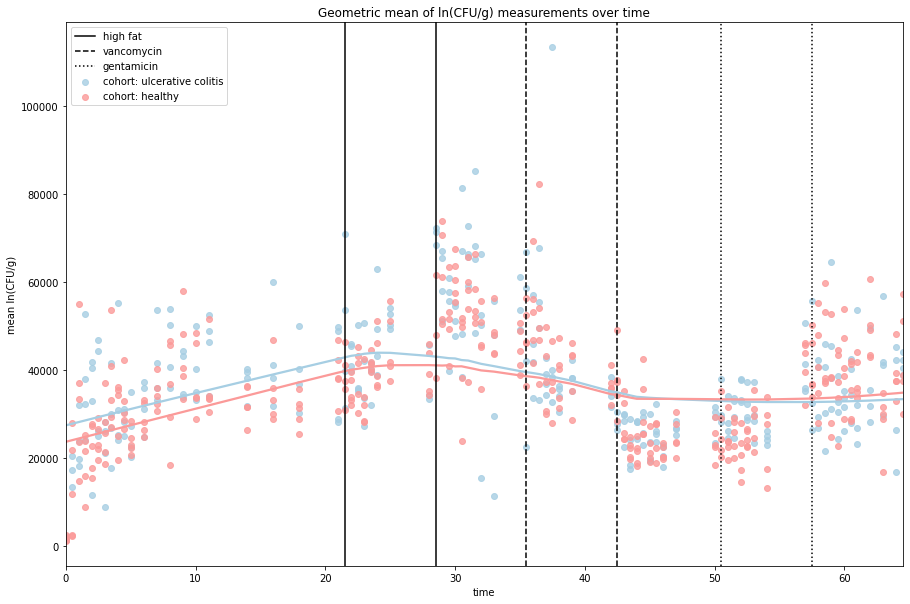

In [ ]:
# Create plot showing the change in the mean biomass concentration over time for each mouse cohort
qpcr2 = qpcr.merge(metadata, on='sampleID')
qpcr2['cohort'] = get_cohorts(qpcr2.subject)
qpcr2['treatment_state'] = get_treatment_states(qpcr2.time)

colors = ['#a6cee3', '#fb9a99']
fig, ax = plt.subplots(figsize=(15,10))
for j, cohort in enumerate(qpcr2.cohort.unique()):
  subject_df = qpcr2.loc[qpcr2.cohort==cohort].copy()
  plot = sns.regplot(data=subject_df, x='time', y='geo_mean_l',color=colors[j], label=f'cohort: {cohort}', lowess=True, ax=ax)
plot.set_title('Geometric mean of ln(CFU/g) measurements over time')
plot.axvline(21.5,color= 'black', label='high fat')
plot.set_ylabel('mean ln(CFU/g)')
plot.axvline(28.5,color= 'black')
plot.axvline(35.5,color= 'black',linestyle='--', label='vancomycin')
plot.axvline(42.5,color= 'black',linestyle='--')
plot.axvline(50.5,color= 'black',linestyle=':', label='gentamicin')
plot.axvline(57.5,color= 'black',linestyle=':')
plot.legend()
plt.show()


Plotting the mean log of relative abundance for the healthy and UC mice, we find that the regression line for the UC mice samples are higher than the healthy mice, although this difference subsides after the first perturbation (Vancomycin). 


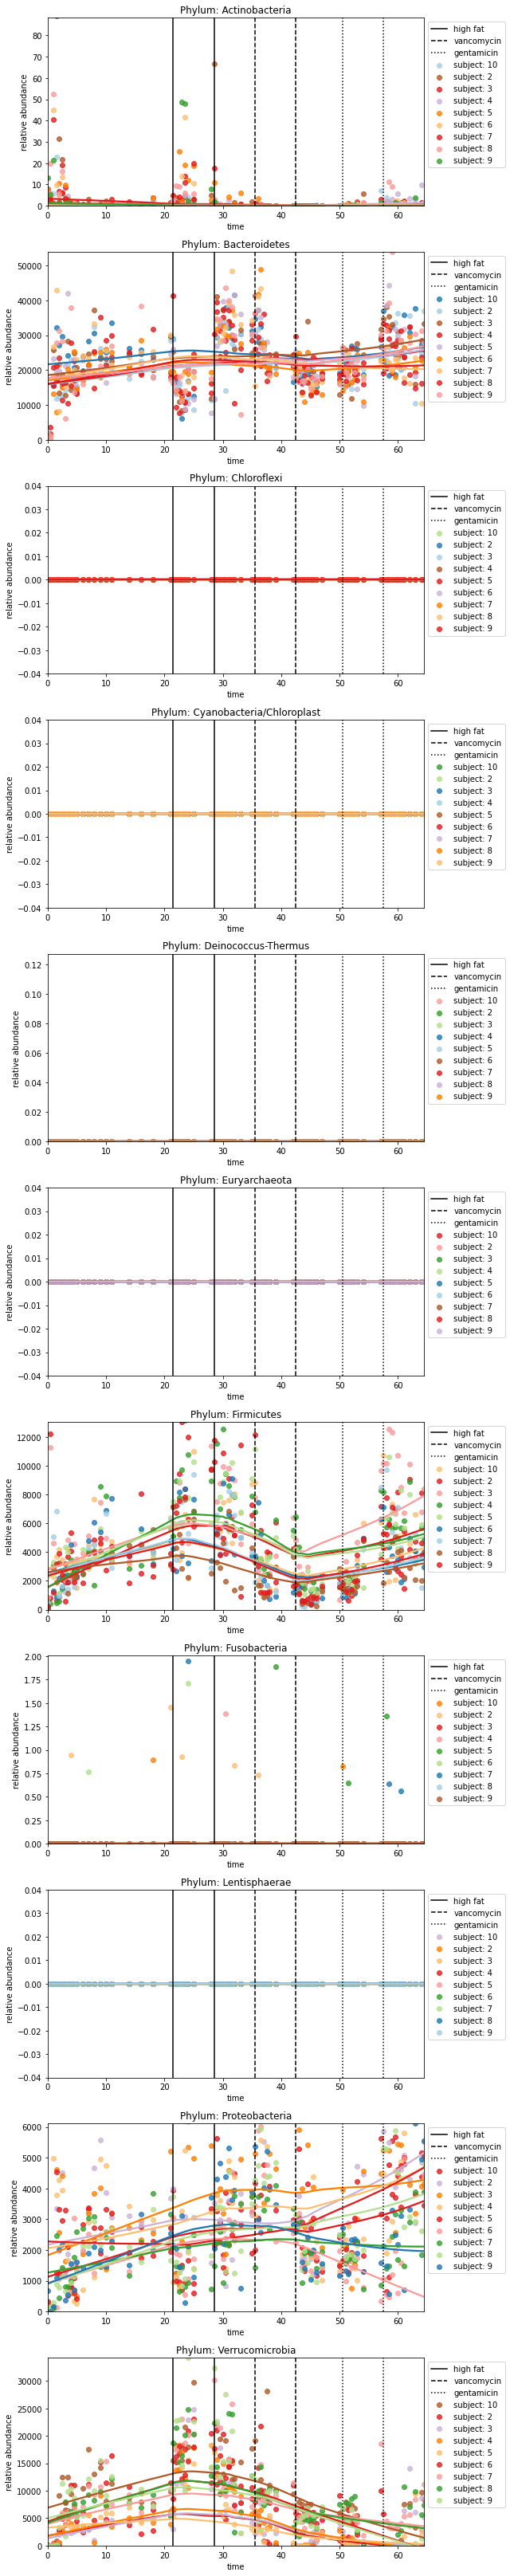

In [ ]:
#Get the standardized relative abundance of each phylum for each mouse (each curve on a given plot represents a mouse)
phylum_abundance = abundance_df_trans.groupby(level='Phylum',axis=1).sum().merge(metadata, left_index=True, right_on='sampleID')
phylum_abundance['cohort'] = get_cohorts(phylum_abundance.subject)
phylum_abundance['treatment_state'] = get_treatment_states(phylum_abundance.time)

colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#e31a1c','#b15928']
fig, axs = plt.subplots(11,1, figsize=(9,45))
for i, bact in enumerate(phylum_abundance.columns[:-5]):
    counter=0
    for subj in phylum_abundance.subject.unique():
        subject_df = phylum_abundance.loc[phylum_abundance.subject==subj].copy()
        ylim = np.max(subject_df[bact])-1
        plot = sns.regplot(x=subject_df.time, y=subject_df[bact], ax=axs[i], color=colors[i + counter], label=f'subject: {subj}', lowess=True)
        plot.set_title(f'{bact}')
        plot.set_title(f'Phylum: {bact}')
        plot.set_ylabel('relative abundance')
        if ylim>0:
            plot.set_ylim(0,ylim)
        else:
            plot.set_ylim(-0.04, 0.04)

        counter = counter -1
    plot.axvline(21.5,color= 'black', label='high fat')
    plot.axvline(28.5,color= 'black')
    plot.axvline(35.5,color= 'black',linestyle='--', label='vancomycin')
    plot.axvline(42.5,color= 'black',linestyle='--')
    plot.axvline(50.5,color= 'black',linestyle=':', label='gentamicin')
    plot.axvline(57.5,color= 'black',linestyle=':')
    plot.legend(bbox_to_anchor=(1, 1), loc=2)
fig.tight_layout()

We plot the data for each of the 11 phylums, labelled by the subject number the samples were taken from. We then plot the 11 phylums labeled by the mice cohorts, healthy fecal matter and UC fecal matter (See next group of plots). The EDA suggests that the differences related to the perturbations account for more variation than the differences between two experimental groups when looking at the phylum level.


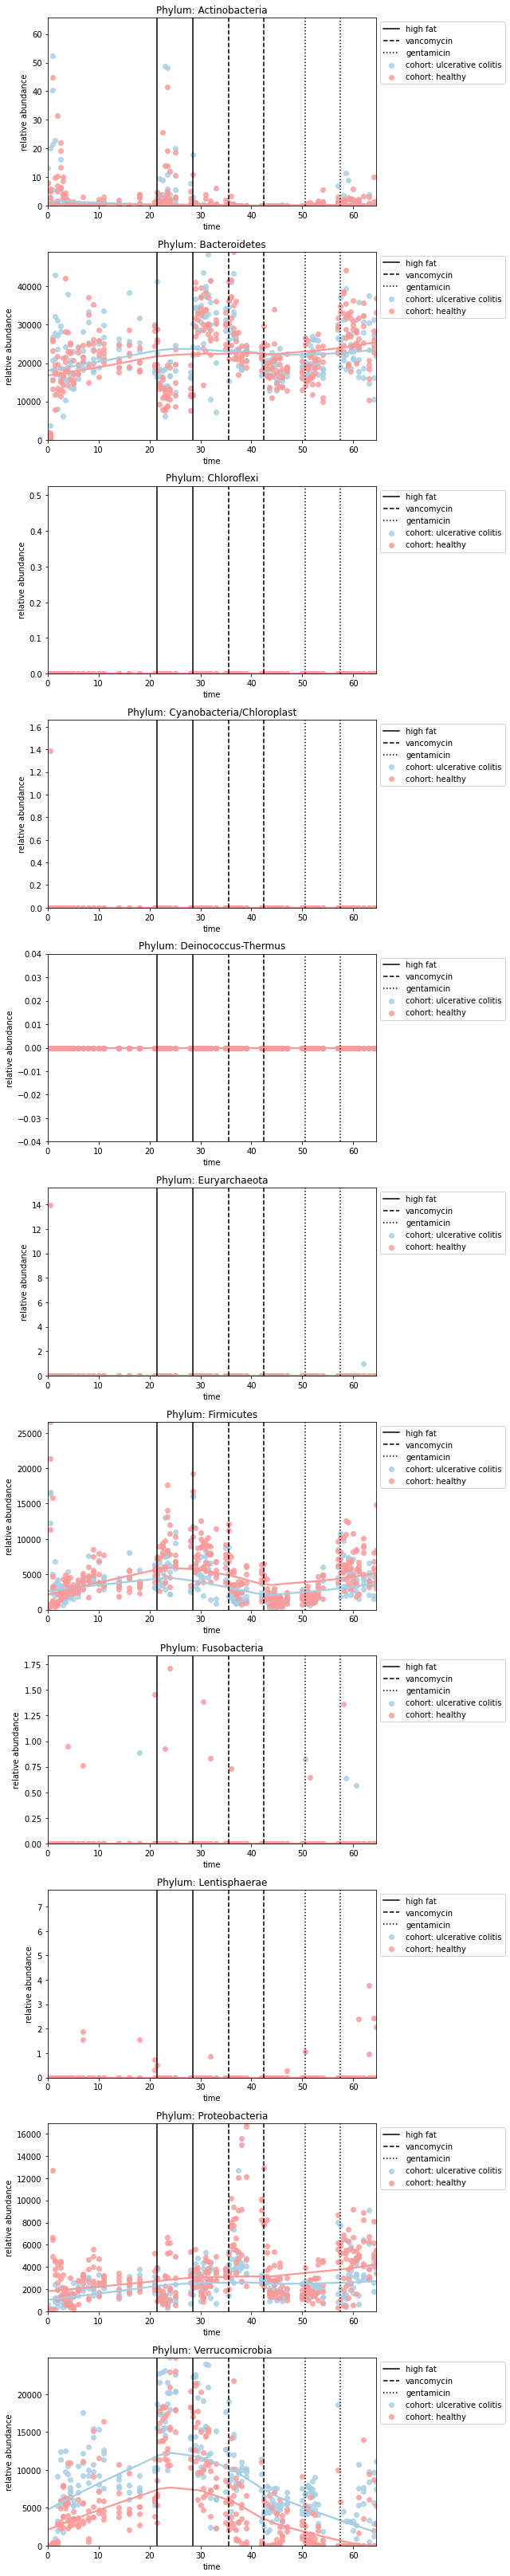

In [ ]:
#This code gives the standardized relative abundance of each phylum for each mouse cohort (each curve on a given plot represents a cohort)

colors = ['#a6cee3', '#fb9a99']#['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#e31a1c','#b15928']
fig, axs = plt.subplots(11,1, figsize=(9,45))
for i, bact in enumerate(phylum_abundance.columns[:-5]):
    counter=0
    for j, subj in enumerate(phylum_abundance.cohort.unique()):
        subject_df = phylum_abundance.loc[phylum_abundance.cohort==subj].copy()
        ylim = np.max(subject_df[bact])-1
        plot = sns.regplot(x=subject_df.time, y=subject_df[bact], ax=axs[i], color=colors[j], label=f'cohort: {subj}', lowess=True)
        plot.set_title(f'{bact}')
        plot.set_title(f'Phylum: {bact}')
        plot.set_ylabel('relative abundance')
        if ylim>0:
            plot.set_ylim(0,ylim)
        else:
            plot.set_ylim(-0.04, 0.04)

        counter = counter -1
    plot.axvline(21.5,color= 'black', label='high fat')
    plot.axvline(28.5,color= 'black')
    plot.axvline(35.5,color= 'black',linestyle='--', label='vancomycin')
    plot.axvline(42.5,color= 'black',linestyle='--')
    plot.axvline(50.5,color= 'black',linestyle=':', label='gentamicin')
    plot.axvline(57.5,color= 'black',linestyle=':')
    plot.legend(bbox_to_anchor=(1, 1), loc=2)
fig.tight_layout()

We used Principal Component Analysis, a dimensionality reduction technique that can help visualize variation in the data at the phylum level, but there is not a lot of variation between the first two principal components, so this may not be the best way to assess the groupings. 

Variance explained by first 2 components (using Phylum) = 0.2739


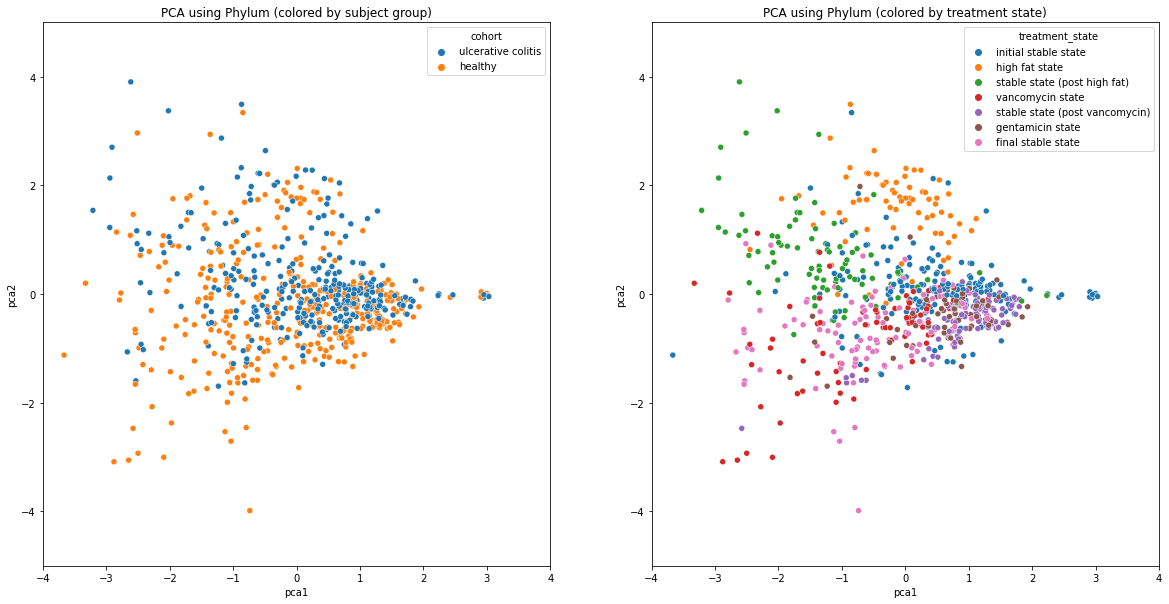

In [ ]:
# Run PCA using phyla and color by cohort and treatment state

scaler = StandardScaler()
scaled_phylum_abundance = scaler.fit_transform(phylum_abundance.iloc[:,:-5])

pca = PCA(n_components=2)
#asv_pca = pca.fit_transform(asv_abundance.iloc[:,:-5])
asv_pca = pca.fit_transform(scaled_phylum_abundance)
print(f'Variance explained by first 2 components (using Phylum) = {np.sum(pca.explained_variance_ratio_):.4f}')
phylum_abundance_pca_df = pd.DataFrame({'pca1': asv_pca[:,0],
                           'pca2': asv_pca[:,1],
                           'treatment_state': phylum_abundance.treatment_state,
                           'cohort': phylum_abundance.cohort})

fig, axs = plt.subplots(1,2, figsize=(20,10))
plot1 = sns.scatterplot(data=phylum_abundance_pca_df, x='pca1', y='pca2', hue='cohort', ax=axs[0])
plot1.set_title('PCA using Phylum (colored by subject group)')
plot1.set_xlim(-4,4)
plot1.set_ylim(-5,5)
plot2 = sns.scatterplot(data=phylum_abundance_pca_df, x='pca1', y='pca2',hue='treatment_state', ax=axs[1])
plot2.set_title('PCA using Phylum (colored by treatment state)')
plot2.set_xlim(-4,4)
plot2.set_ylim(-5,5)


plt.show()

Variance explained by first 2 components = 0.0633


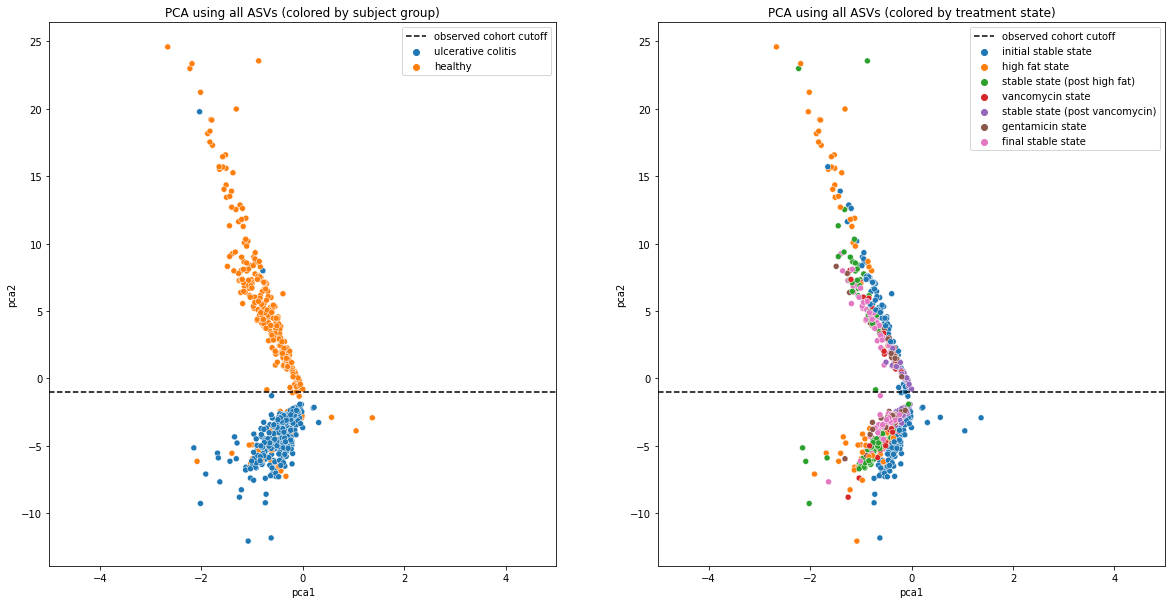

In [ ]:
# Create PCA plots at the ASV level
asv_abundance = abundance_df_trans.groupby(level='name',axis=1).sum().merge(metadata, left_index=True, right_on='sampleID')
asv_abundance['cohort'] = get_cohorts(asv_abundance.subject)
asv_abundance['treatment_state'] = get_treatment_states(asv_abundance.time)
scaler = StandardScaler()
scaled_asv_abundance = scaler.fit_transform(asv_abundance.iloc[:,:-5])

pca = PCA(n_components=2)
#asv_pca = pca.fit_transform(asv_abundance.iloc[:,:-5])
asv_pca = pca.fit_transform(scaled_asv_abundance)
print(f'Variance explained by first 2 components = {np.sum(pca.explained_variance_ratio_):.4f}')
asv_pca_df = pd.DataFrame({'pca1': asv_pca[:,0],
                           'pca2': asv_pca[:,1],
                           'treatment_state': asv_abundance.treatment_state,
                           'cohort': asv_abundance.cohort})

fig, axs = plt.subplots(1,2, figsize=(20,10))
plot1 = sns.scatterplot(data=asv_pca_df, x='pca1', y='pca2', hue='cohort', ax=axs[0])
plot1.set_title('PCA using all ASVs (colored by subject group)')
plot1.set_xlim(-5,5)
plot1.axhline(-1, color='black',label='observed cohort cutoff',linestyle='--')
plot1.legend()
plot2 = sns.scatterplot(data=asv_pca_df, x='pca1', y='pca2',hue='treatment_state', ax=axs[1])
plot2.set_xlim(-5,5)
plot2.axhline(-1, color='black',label='observed cohort cutoff',linestyle='--')
plot2.legend()
plot2.set_title('PCA using all ASVs (colored by treatment state)')
plt.show()

In order to try and find more differentiation between experimental groups and interventions, we chose to look at the ASV level (a full flip from phylum) by comparing the PCA plots for all 1473 ASVs We see an extremely clear distinction between the mice treated with healthy feces and UC positive feces. Additionally, there is some, albeit imperfect separation between perturbations.


In [ ]:
# Wrangling data for top 100 ASVs with highest relative abundance
topN_total_abundances = asv_abundance.iloc[:,:-5].sum().sort_values(ascending=False).head(100)
topN_asv_names = list(topN_total_abundances.index)
topN_asv_abundance = abundance_df_trans.groupby(level='name',axis=1).sum()[topN_asv_names].merge(metadata, left_index=True, right_on='sampleID')
topN_asv_abundance['cohort'] = get_cohorts(topN_asv_abundance.subject)
topN_asv_abundance['treatment_state'] = get_treatment_states(topN_asv_abundance.time)

top10_asv_names = list(topN_total_abundances.head(10).index)
top10_asv_abundance = abundance_df_trans.groupby(level='name',axis=1).sum()[top10_asv_names].merge(metadata, left_index=True, right_on='sampleID')
top10_asv_abundance['cohort'] = get_cohorts(top10_asv_abundance.subject)
top10_asv_abundance['treatment_state'] = get_treatment_states(top10_asv_abundance.time)

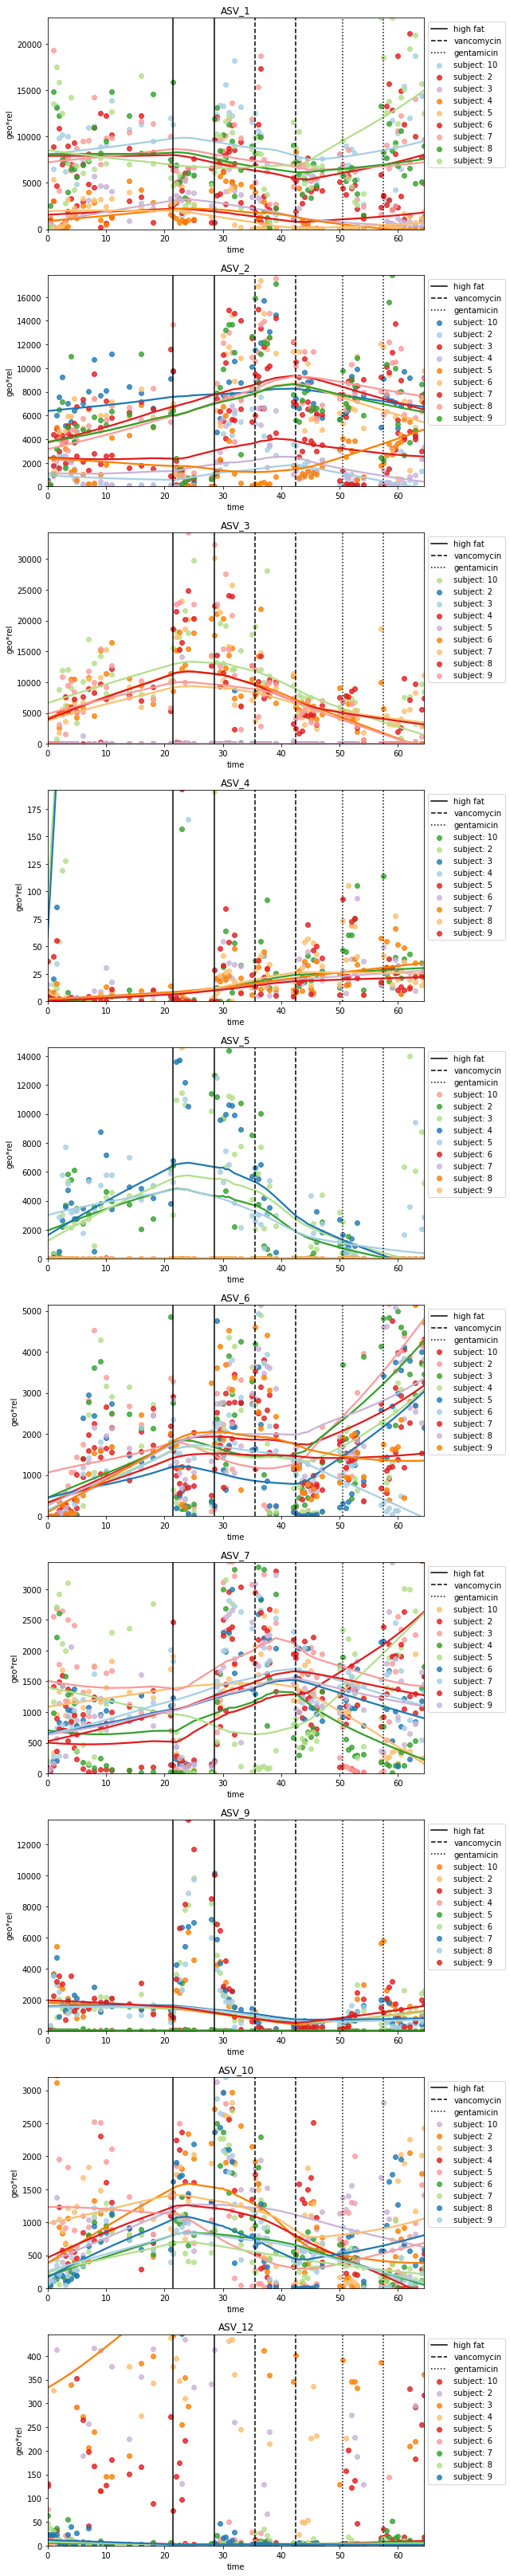

In [ ]:
# This code gives the standardized relative abundance of top 10 ASVs for each mouse (each curve on a given plot represents a mouse)
colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#e31a1c']
fig, axs = plt.subplots(10,1, figsize=(9,45))
for i, bact in enumerate(top10_asv_abundance.columns.drop(['treatment_state','cohort','sampleID','subject','time'])):
    counter=0
    for subj in top10_asv_abundance.subject.unique():
        subject_df = top10_asv_abundance.loc[top10_asv_abundance.subject==subj].copy()
        ylim = np.max(subject_df[bact])-1
        plot = sns.regplot(x=subject_df.time, y=subject_df[bact], ax=axs[i], color=colors[i + counter], label=f'subject: {subj}', lowess=True)
        plot.set_title(f'{bact}')
        plot.set_title(f'{bact}')
        plot.set_ylabel('geo*rel')
        if ylim>0:
            plot.set_ylim(0,ylim)
        else:
            plot.set_ylim(-0.04, 0.04)

        counter = counter -1
    plot.axvline(21.5,color= 'black', label='high fat')
    plot.axvline(28.5,color= 'black')
    plot.axvline(35.5,color= 'black',linestyle='--', label='vancomycin')
    plot.axvline(42.5,color= 'black',linestyle='--')
    plot.axvline(50.5,color= 'black',linestyle=':', label='gentamicin')
    plot.axvline(57.5,color= 'black',linestyle=':')
    plot.legend(bbox_to_anchor=(1, 1), loc=2)
fig.tight_layout()

We then analyzed the effect of the perturbations for individual ASVs. We selected the top 10 ASVs by their relative abundances, and found that some ASVs , such as ASV 1, have different abundances across the two mice cohorts. Others such as ASV 3, 4, and 5 show similar trends across the two cohorts. And yet others such as ASV 6 and 7 have very unpredictable abundances, especially after the two perturbations. This raised further questions about the reasons behind these differences in abundances between mice cohorts and across perturbations.


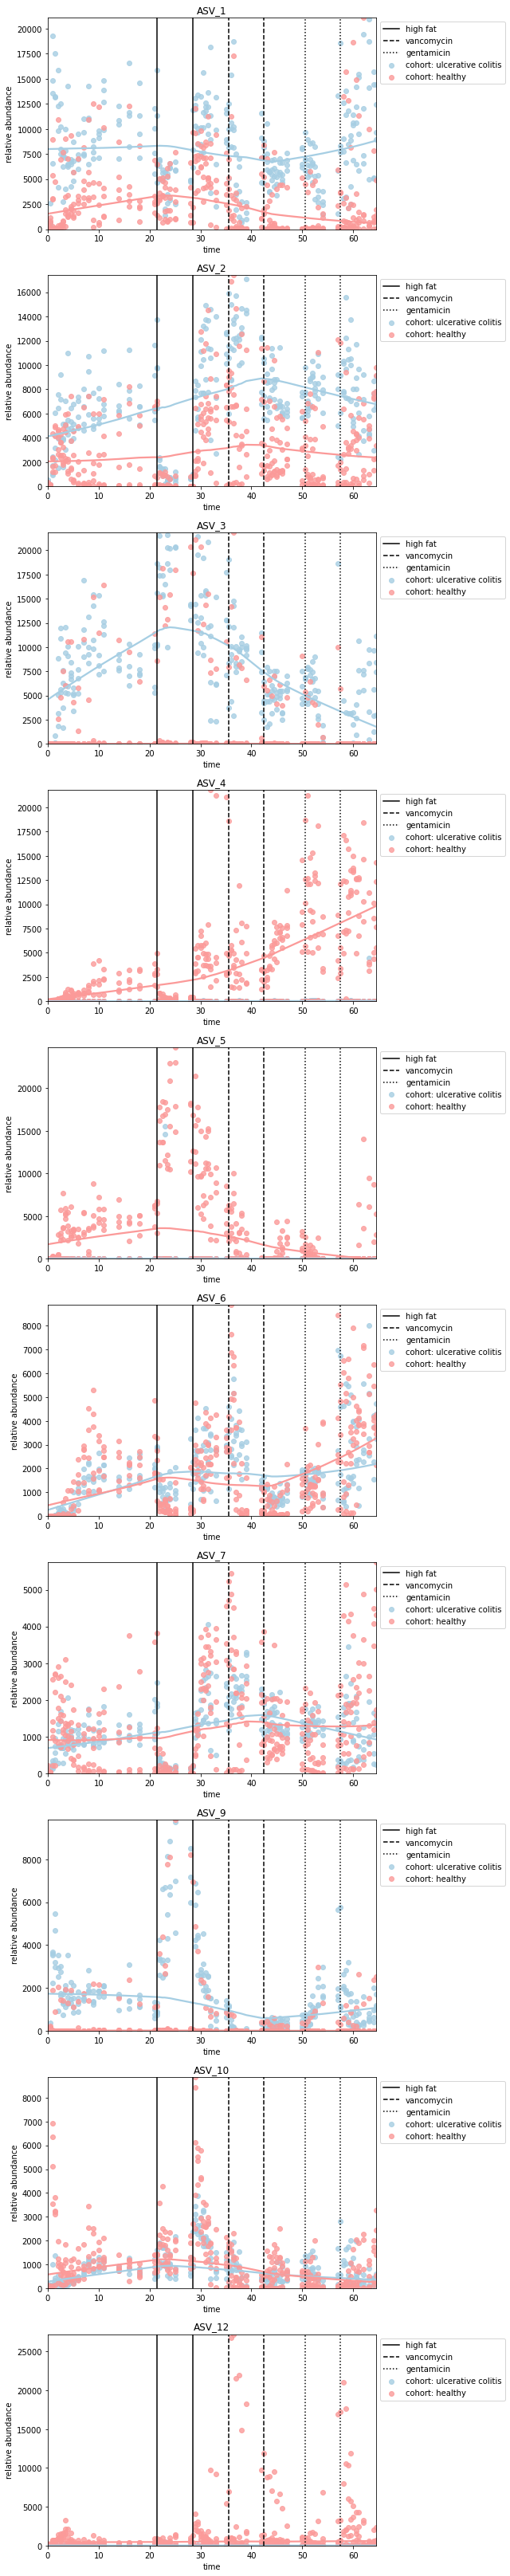

In [ ]:
#This code gives the standardized of top 10 ASVs for each mouse cohort (each curve on a given plot represents a cohort)
colors = ['#a6cee3', '#fb9a99']#,'#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#e31a1c']
fig, axs = plt.subplots(10,1, figsize=(9,45))
for i, bact in enumerate(top10_asv_abundance.columns.drop(['treatment_state','cohort','sampleID','subject','time'])):
    counter=0
    for j, subj in enumerate(top10_asv_abundance.cohort.unique()):
        subject_df = top10_asv_abundance.loc[top10_asv_abundance.cohort==subj].copy()
        ylim = np.max(subject_df[bact])-1
        plot = sns.regplot(x=subject_df.time, y=subject_df[bact], ax=axs[i], color=colors[j], label=f'cohort: {subj}', lowess=True)
        plot.set_title(f'{bact}')
        plot.set_title(f'{bact}')
        plot.set_ylabel('relative abundance')
        if ylim>0:
            plot.set_ylim(0,ylim)
        else:
            plot.set_ylim(-0.04, 0.04)

        counter = counter -1
    plot.axvline(21.5,color= 'black', label='high fat')
    plot.axvline(28.5,color= 'black')
    plot.axvline(35.5,color= 'black',linestyle='--', label='vancomycin')
    plot.axvline(42.5,color= 'black',linestyle='--')
    plot.axvline(50.5,color= 'black',linestyle=':', label='gentamicin')
    plot.axvline(57.5,color= 'black',linestyle=':')
    plot.legend(bbox_to_anchor=(1, 1), loc=2)
fig.tight_layout()

Variance explained by first 2 components (top 100 rel. abundant ASVs) = 0.2761


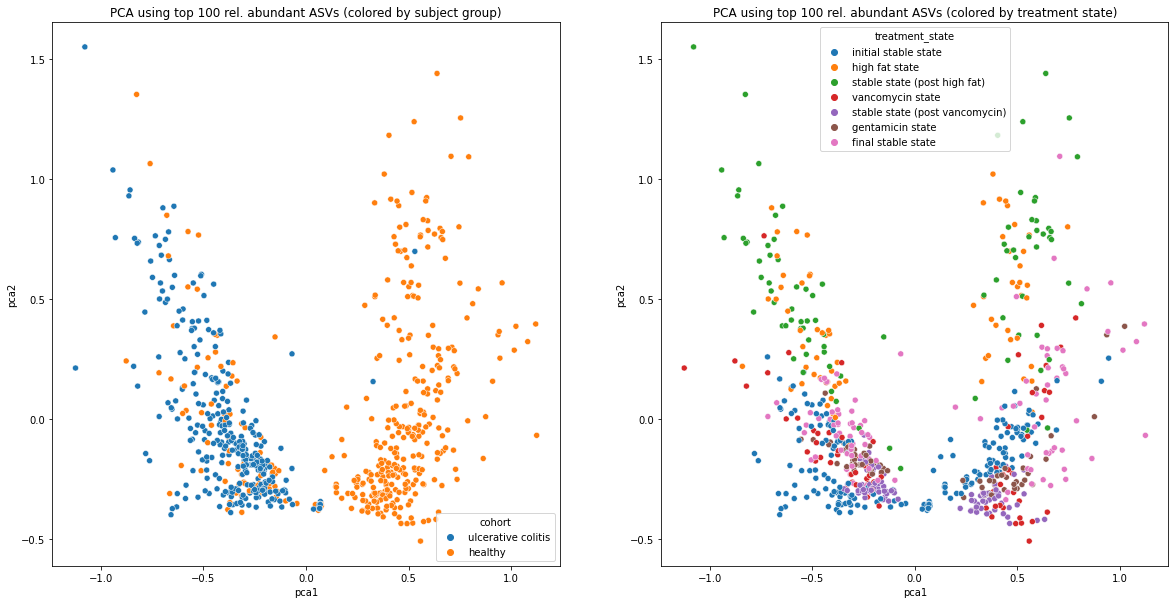

In [ ]:
# Run PCA on the top 100 most abundant ASVs
scaler = MinMaxScaler(feature_range=(1,2))
#scaler = StandardScaler()
scaled_topN_asv_abundance = scaler.fit_transform(topN_asv_abundance.iloc[:,:-5])

pca = PCA(n_components=2)
#asv_pca = pca.fit_transform(asv_abundance.iloc[:,:-5])
asv_pca = pca.fit_transform(scaled_topN_asv_abundance)
print(f'Variance explained by first 2 components (top 100 rel. abundant ASVs) = {np.sum(pca.explained_variance_ratio_):.4f}')
topN_asv_pca_df = pd.DataFrame({'pca1': asv_pca[:,0],
                           'pca2': asv_pca[:,1],
                           'treatment_state': topN_asv_abundance.treatment_state,
                           'cohort': topN_asv_abundance.cohort})

fig, axs = plt.subplots(1,2, figsize=(20,10))
plot1 = sns.scatterplot(data=topN_asv_pca_df, x='pca1', y='pca2', hue='cohort', ax=axs[0])
plot1.set_title('PCA using top 100 rel. abundant ASVs (colored by subject group)')
plot2 = sns.scatterplot(data=topN_asv_pca_df, x='pca1', y='pca2',hue='treatment_state', ax=axs[1])
plot2.set_title('PCA using top 100 rel. abundant ASVs (colored by treatment state)')
plt.show()

We re-ran our PCA plot but for top 100 ASVs by relative abundance. Once again we find a clear separation between the two mice cohorts and more modest differentiation between the different treatment states. 

There is very clearly a difference between mice with ulcerative colitis and healthy mice. The first principal component notes this stark difference, and the second principal component seems to distinguish across the different treatment states reasonably well. Interestingly, the variance across the second component is accounted for similarly by treatment state across the two types of mice. This sugests that perhaps we can expect similar trajectories in the changes in relative abundance of different ASVs across mice types.


As a very preliminary baseline model, we decided to run an autoregression using only a given ASV's change over time to predict itself. We did this to understand if we could get reasonable fits in terms of R^2 on any sort of model as a part of our milestone 2. Ultimately, this model does not use any other information besides the relative abundnacies within the subject and ASV that it's fitting

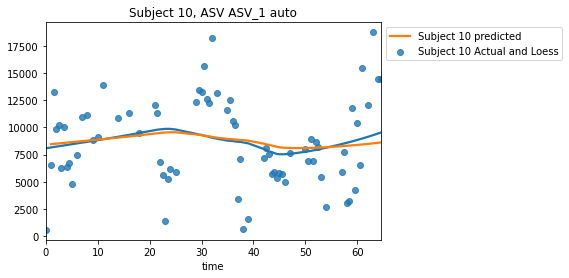

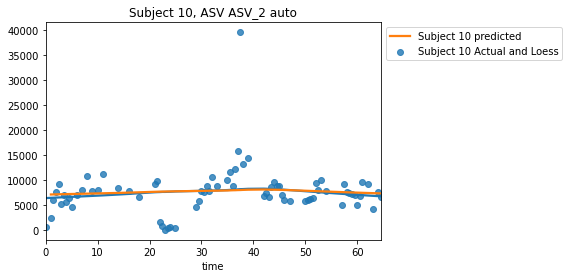

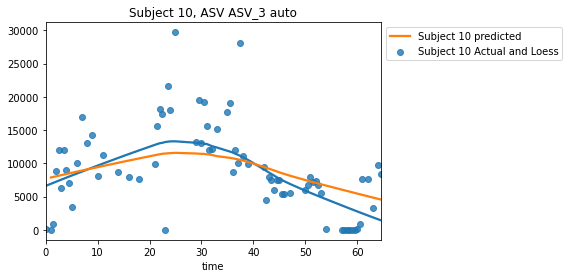

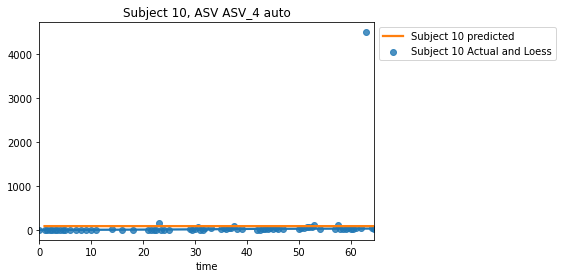

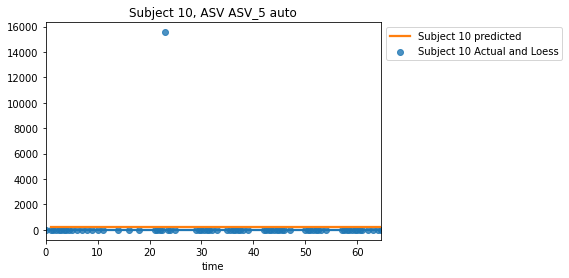

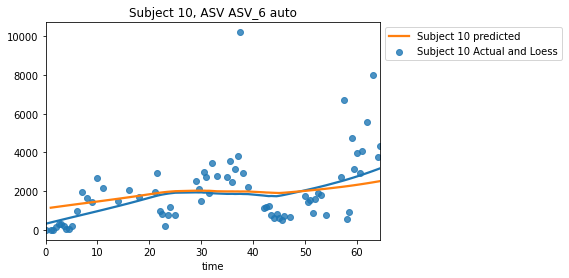

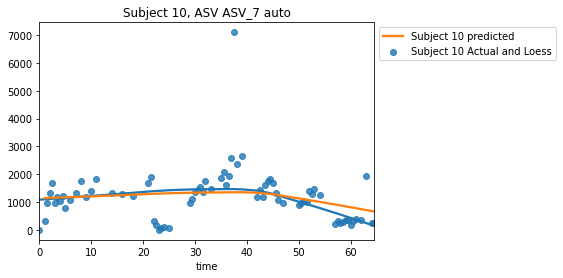

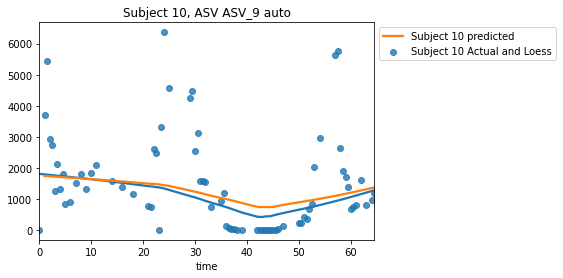

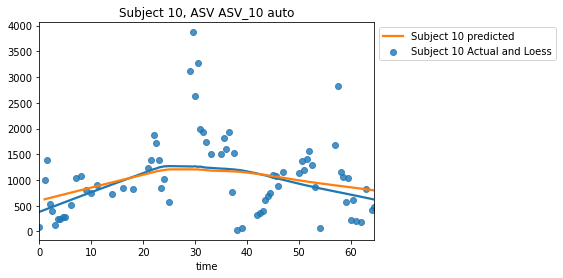

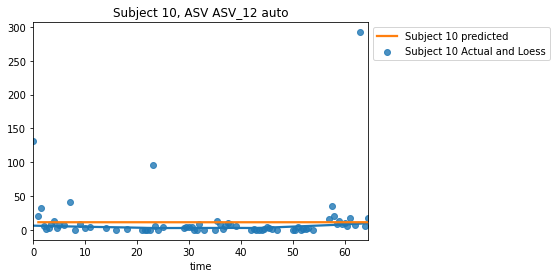

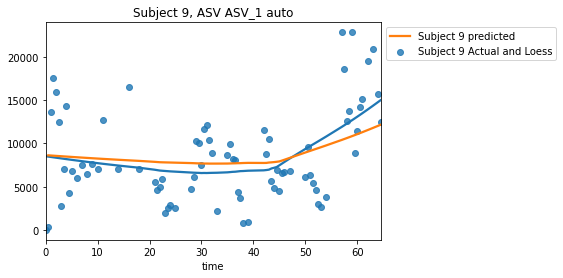

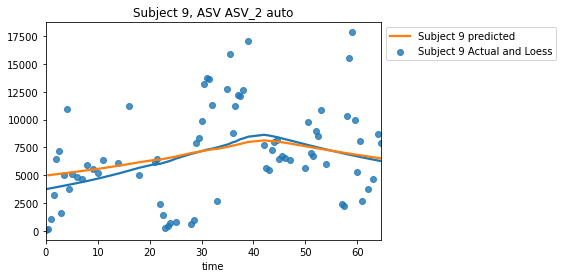

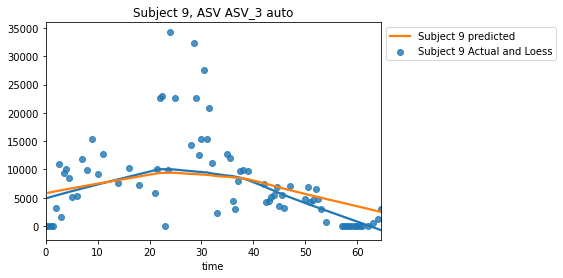

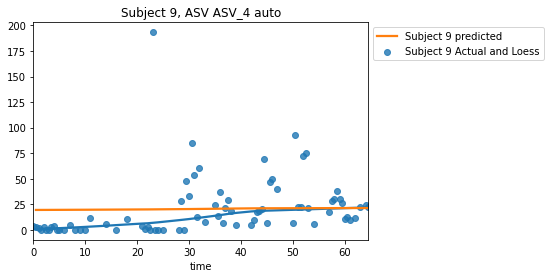

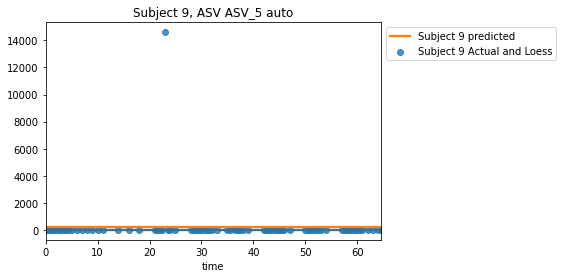

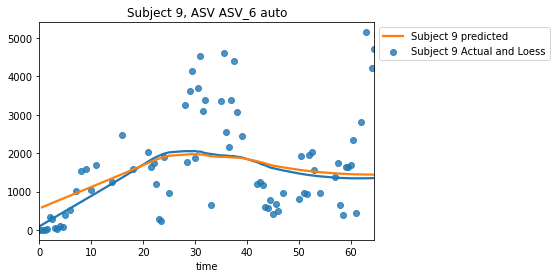

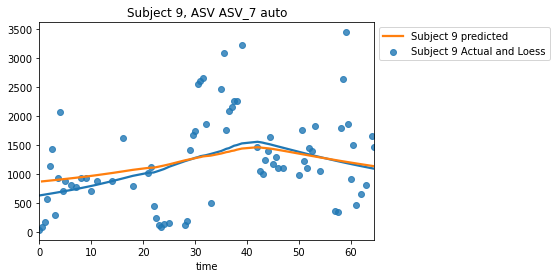

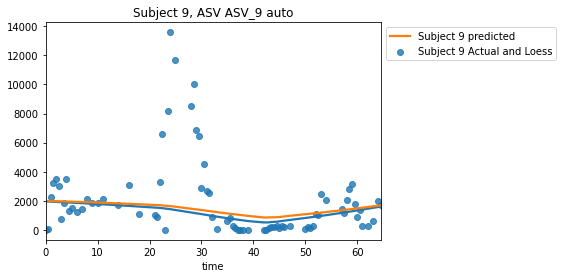

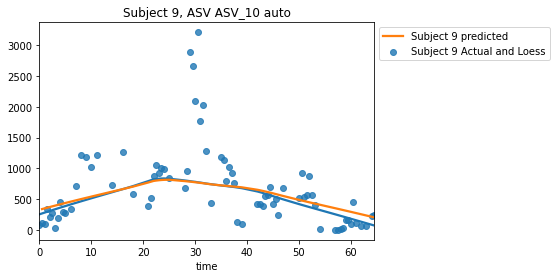

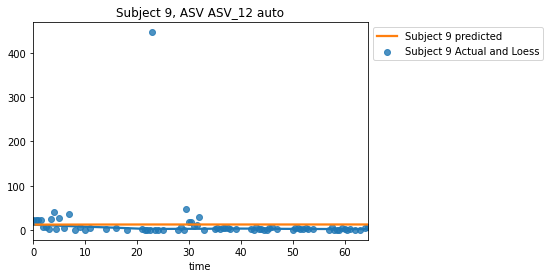

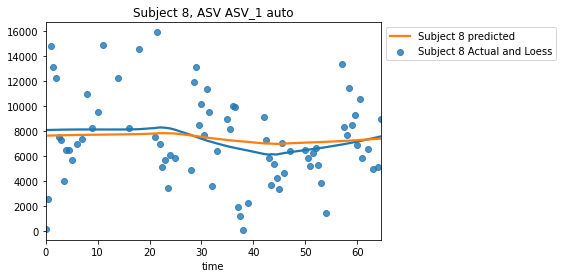

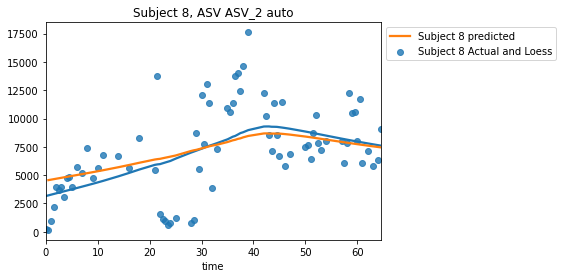

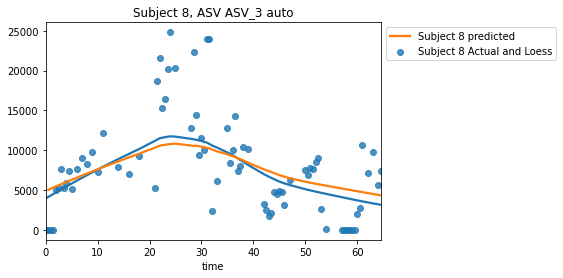

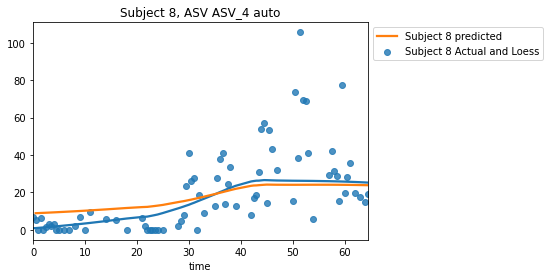

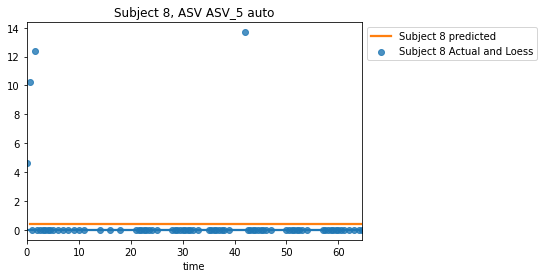

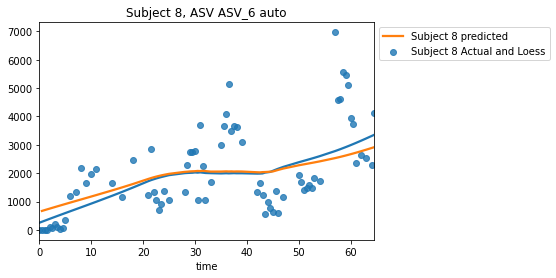

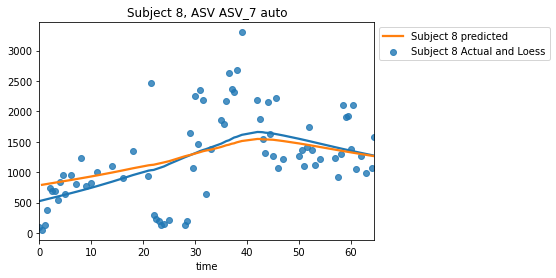

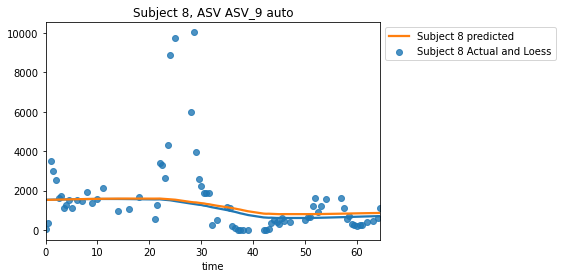

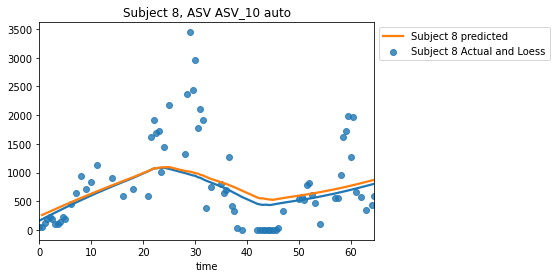

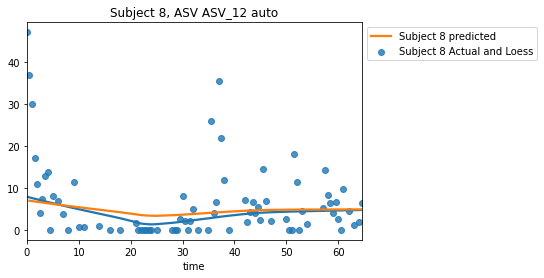

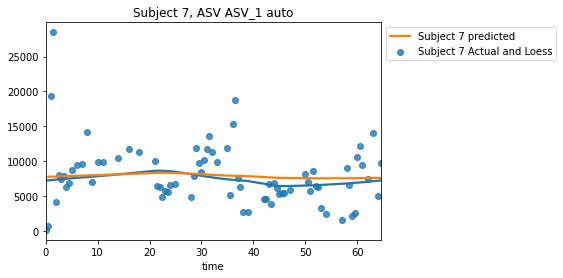

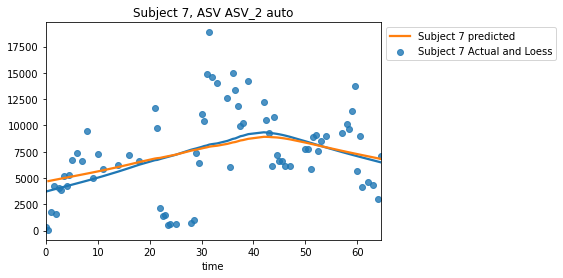

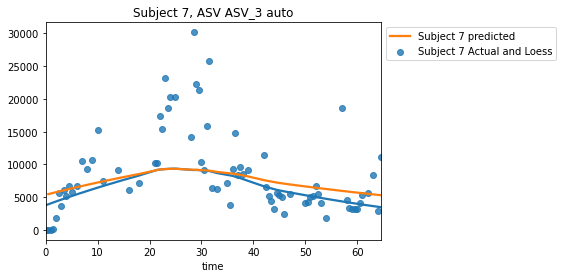

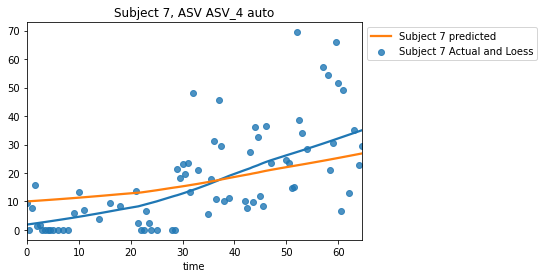

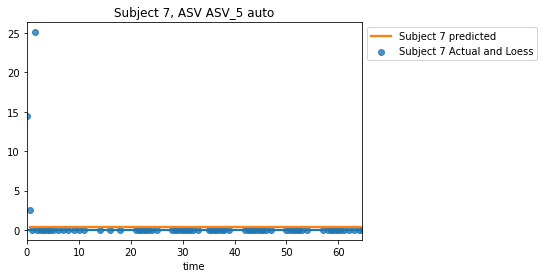

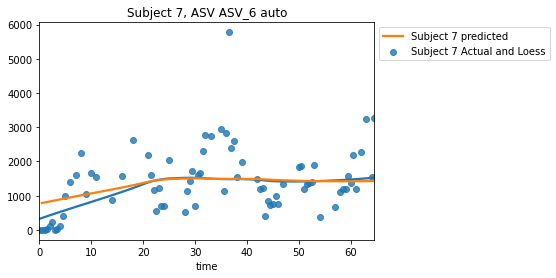

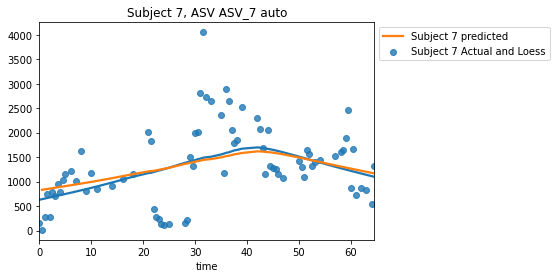

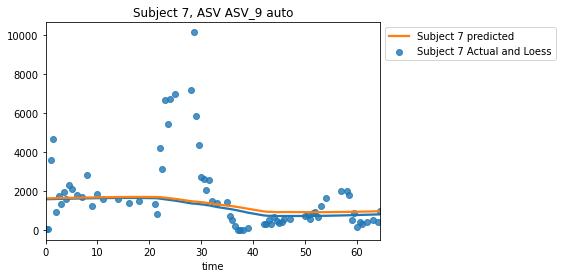

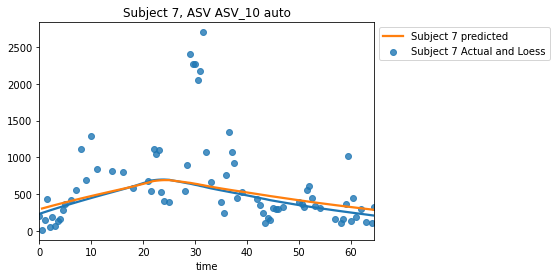

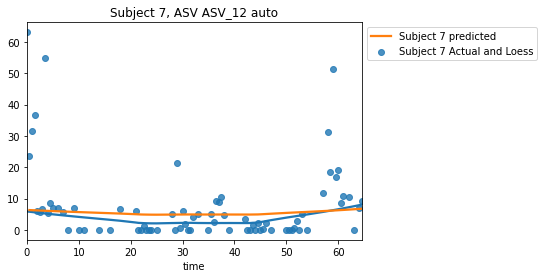

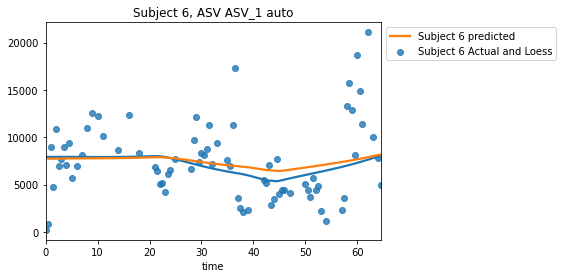

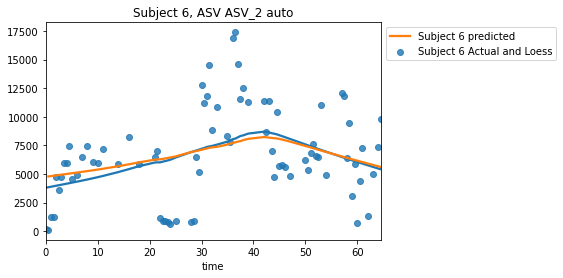

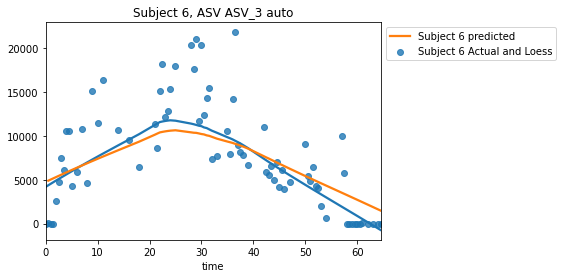

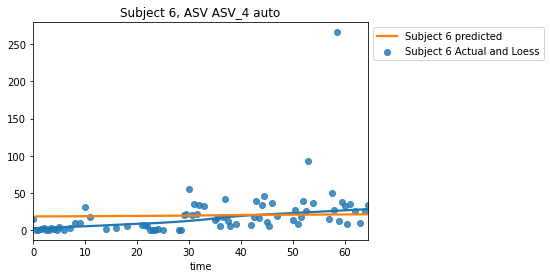

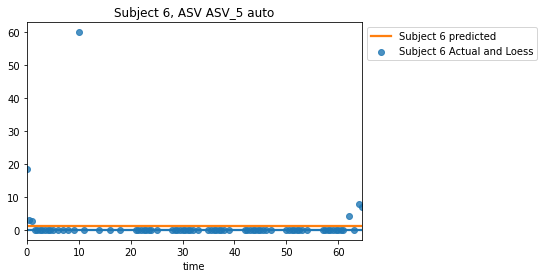

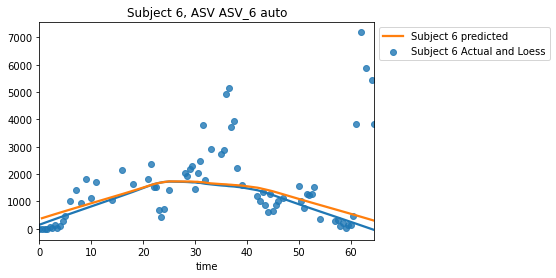

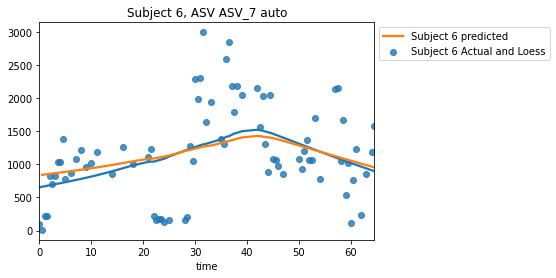

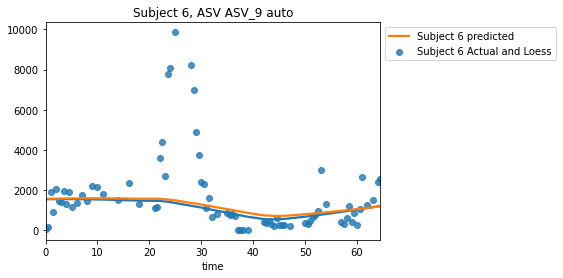

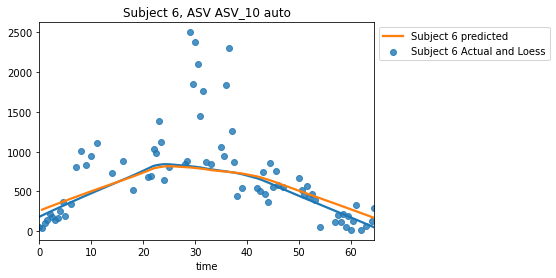

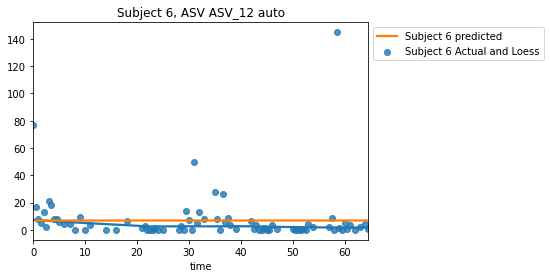

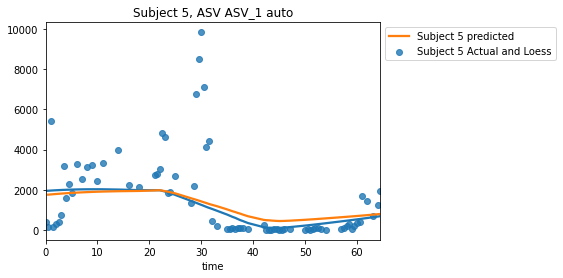

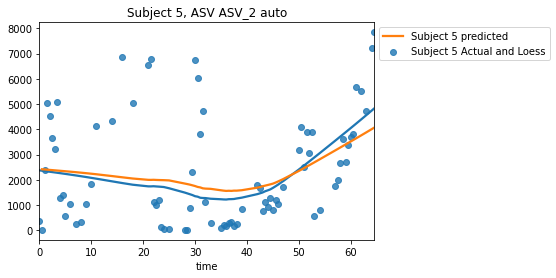

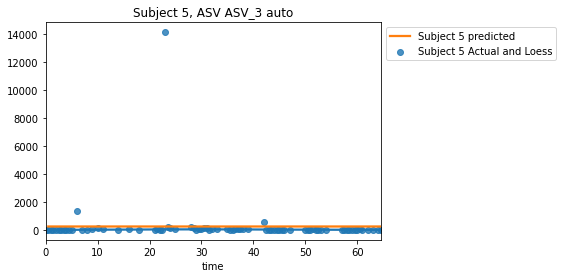

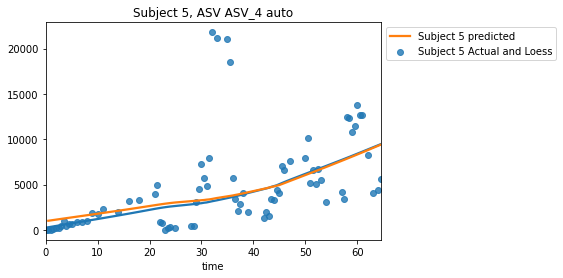

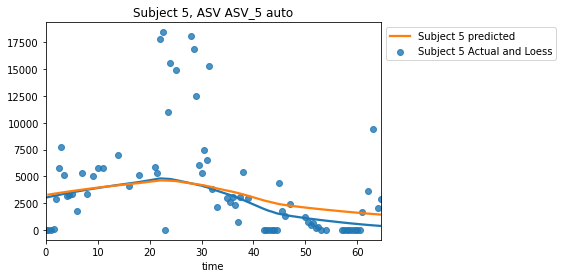

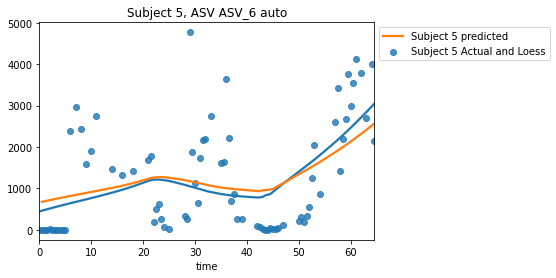

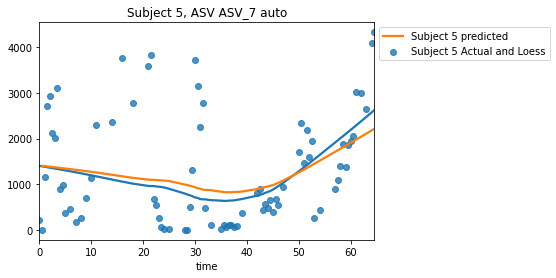

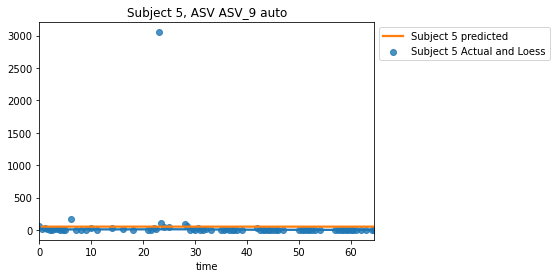

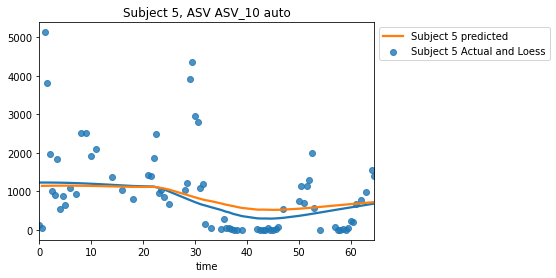

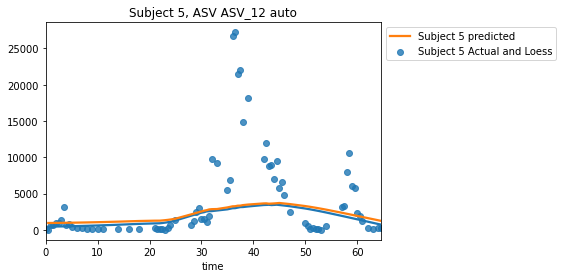

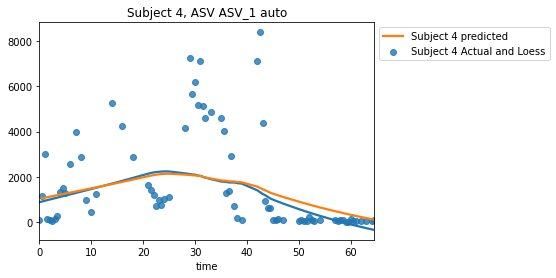

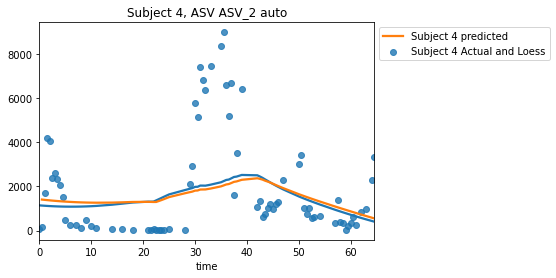

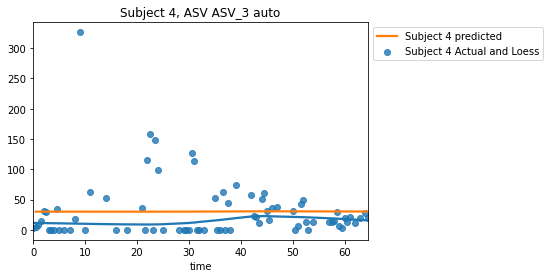

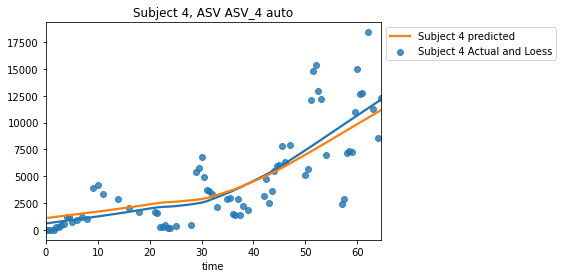

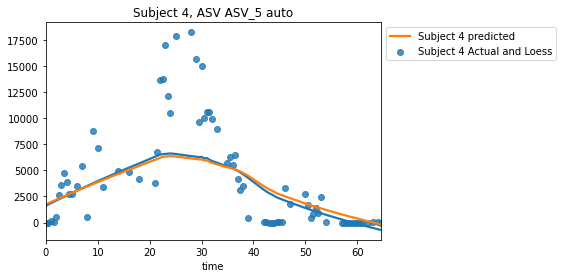

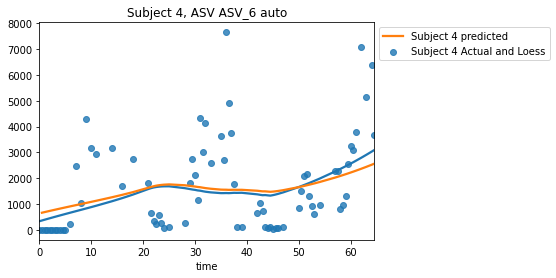

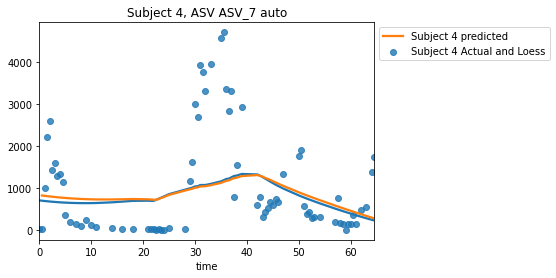

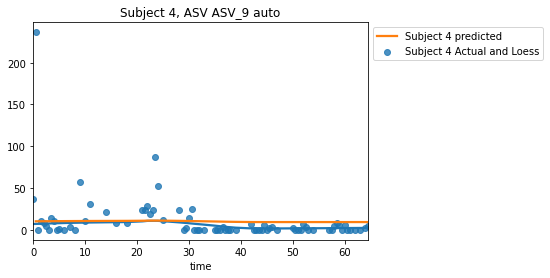

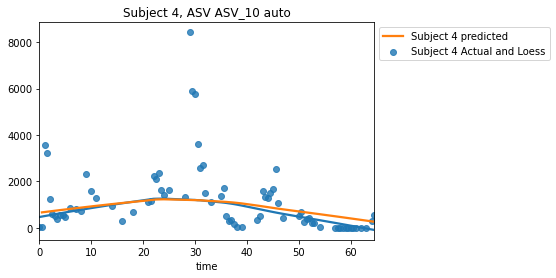

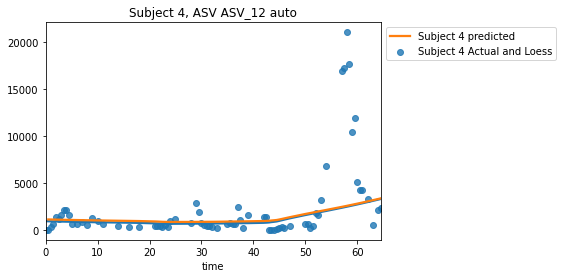

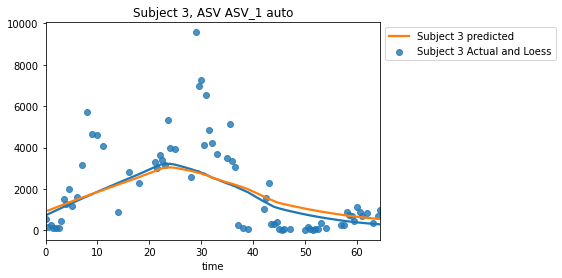

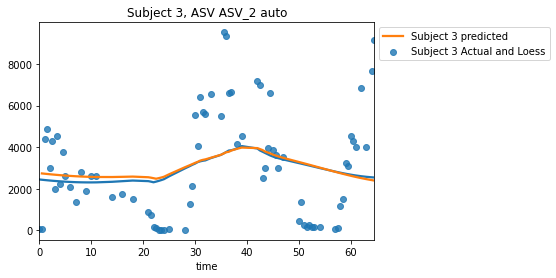

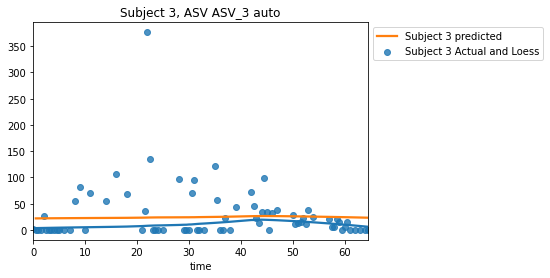

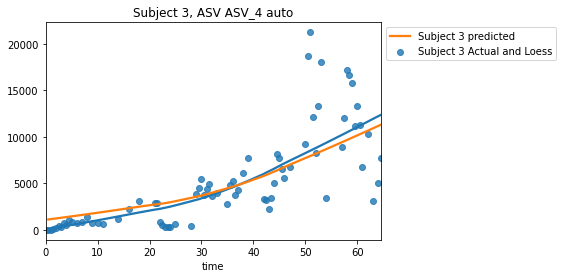

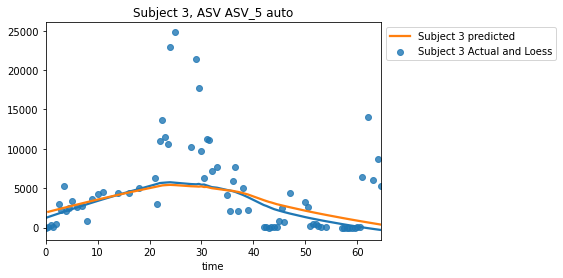

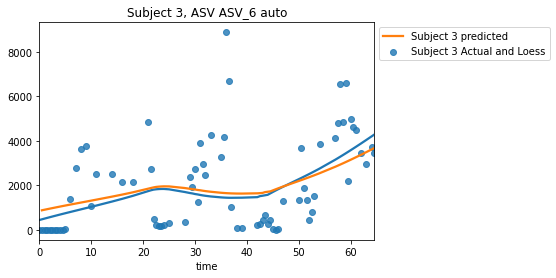

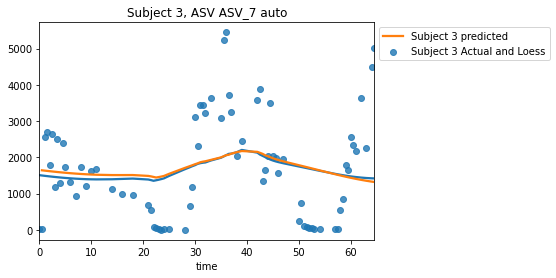

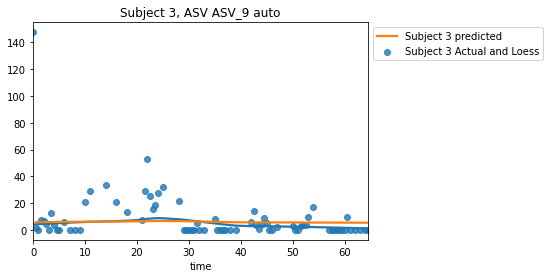

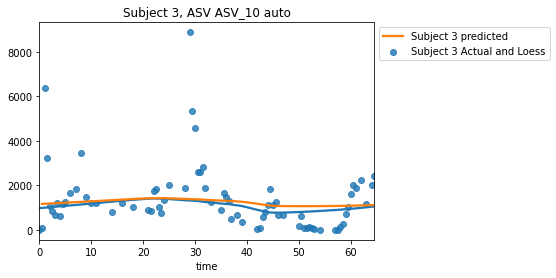

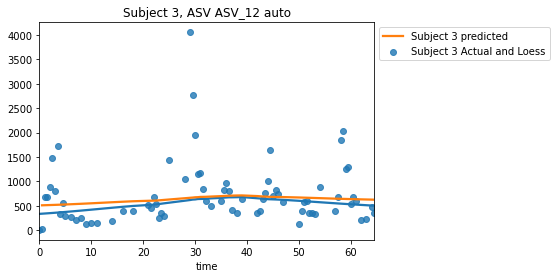

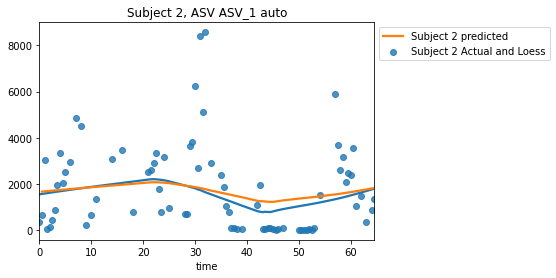

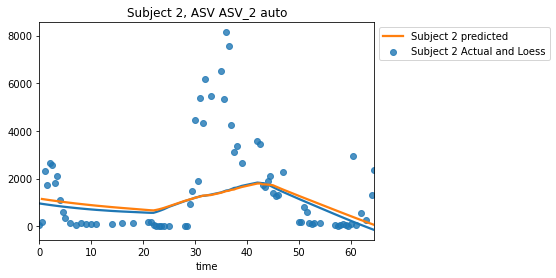

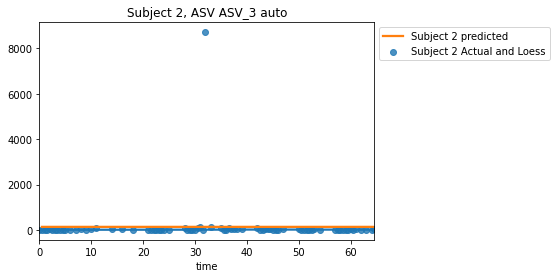

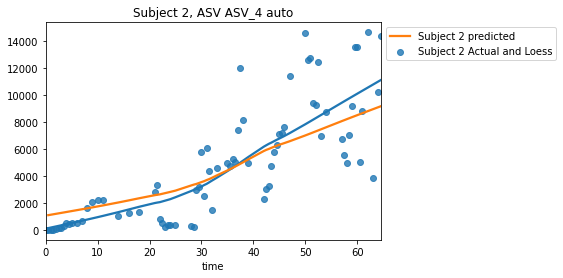

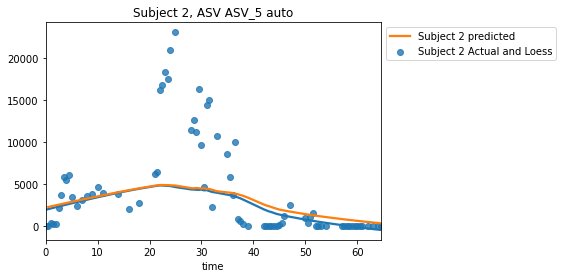

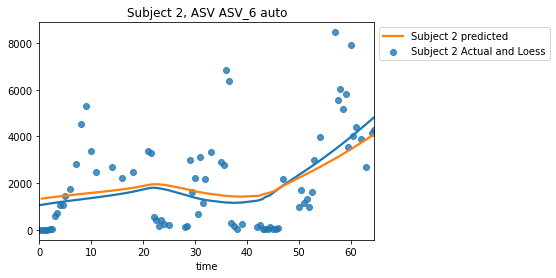

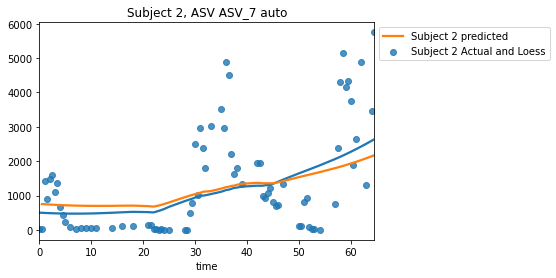

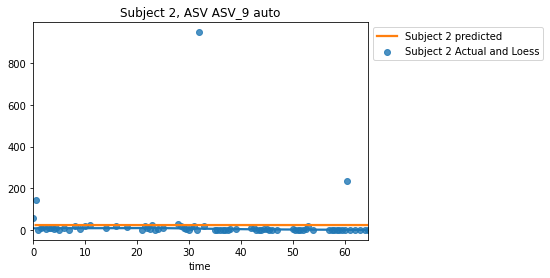

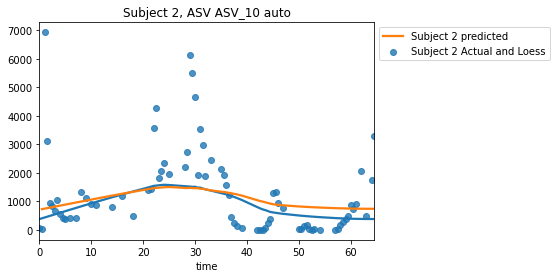

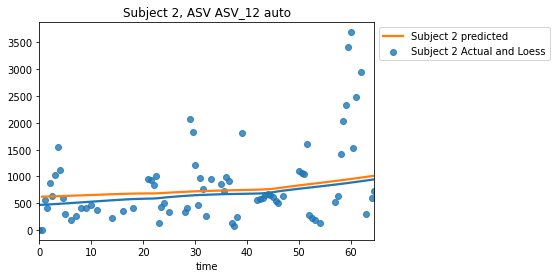

In [ ]:
#fitting a very simple autoregression model for the top abundant ASV's - this is the baseline model

asv_list = ["ASV_1", "ASV_2", "ASV_3",	"ASV_4",	"ASV_5",	"ASV_6",	"ASV_7",	"ASV_9","ASV_10", "ASV_12"]
subject_list = [10,9,8,7,6,5,4,3,2]

#stores a diction of dict - corresponding to bug, then mouse
asv_dict={}

### Create dataset for one mouse and ASV
for subj in subject_list:
# Get needed columns
  glv_df = topN_asv_abundance.loc[topN_asv_abundance["subject"]==subj].sort_values(by='time').reset_index()
  asv_dict[subj] = {}
  for ASV in asv_list:
    mod = AutoReg(glv_df[ASV], lags=1, old_names=False)
    res = mod.fit()
    asv_dict[subj][ASV] = metrics.r2_score(y_true=glv_df[ASV][1:], y_pred=res.predict()[1:])

    plot = sns.regplot(x=glv_df.time, y=glv_df[ASV], scatter=True, label=f"Subject {subj} Actual and Loess", lowess=True)
    plot = sns.regplot(x=glv_df.time, y=res.predict(), scatter=False, label=f"Subject {subj} predicted", lowess=True)
    plot.set_title(f'Subject {subj}, ASV {ASV} auto')
    plot.legend(bbox_to_anchor=(1, 1), loc=2)
    plt.show()

The model has some extremely high R^2 for certain ASV's, but these were not consistent across the two cohorts. For example,the model has high R^2 values for the ASV 9 in the UC positive cohort, but extremely small R^2 for the same ASV in the healthy cohort. With these inconsistent results, it seems clear that we are missing information and potential predictive power that we might be able to improve through clustering, dimensionality reductions, and other kinds of models.

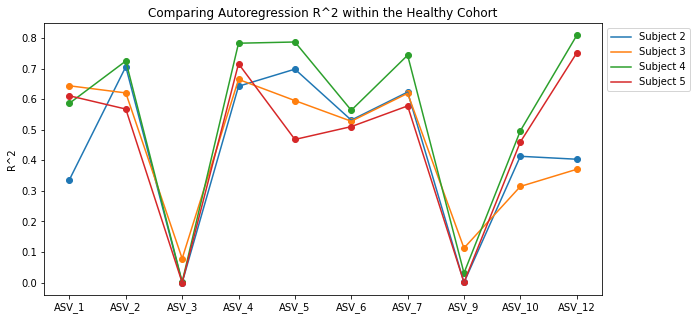

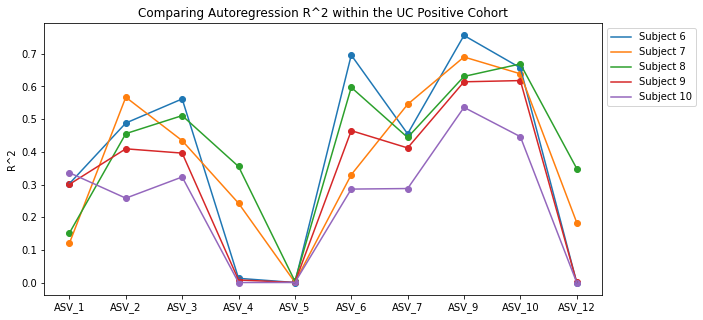

In [ ]:
#plotting the R^2 of in each cohort.
healthy_list = [2,3,4,5]
UC_list = [6,7,8,9,10]
plt.subplots(figsize=(10,5))
for subj in healthy_list:
  plt.plot(list(asv_dict[subj].keys()), list(asv_dict[subj].values()),label = f'Subject {subj}')
  plt.scatter(list(asv_dict[subj].keys()), list(asv_dict[subj].values()))
  plt.title('Comparing Autoregression R^2 within the Healthy Cohort')
  plt.legend(bbox_to_anchor=(1, 1), loc=2)
  plt.ylabel('R^2')
plt.show()
plt.subplots(figsize=(10,5))
for subj in UC_list:
  plt.plot(list(asv_dict[subj].keys()), list(asv_dict[subj].values()),label = f'Subject {subj}')
  plt.scatter(list(asv_dict[subj].keys()), list(asv_dict[subj].values()))
  plt.title('Comparing Autoregression R^2 within the UC Positive Cohort')
  plt.legend(bbox_to_anchor=(1, 1), loc=2)
  plt.ylabel('R^2')
plt.show()

# Clustering the ASVs

## Cluster Using Dynamic Time Warp

We used the Dynamic Time Warp (DTW) algorithm in order to create the distance matrix. We followed the implementation presented in a research article published in 2018 (https://doi.org/10.3389/fmicb.2018.00036). The primary difference between the DTW implemented in this article (and our project) and the traditional DTW algorithm, is that we normalized the distances based on maximum possible distance between the trajectories of two ASVs. Therefore, a distance of 1 would mean that the two trajectories are mirror images of each other, and a distance of 0 means that the two trajectories are exactly the same. 

We clustered the ASVs by 4 clusters according to the similarity of their relative abundance through the time series data. The number of clusters were chosen from observing the distances through the hierarchical clustering dendrogram and from analyzing the silhouette and gap statistic measures.


In [ ]:
# Filter out ASVs that are present in less than 1% of samples
abs_abundance_df_cols = []
for col in counts.columns:
    if ('rel' not in col) & ('georel' not in col):
        abs_abundance_df_cols.append(col)

abs_abundance_df = counts[abs_abundance_df_cols].copy()
abs_abundance_df = abs_abundance_df.merge(asv_and_taxonomy, left_on='Unnamed: 0', right_on='name')
abs_abundance_df.set_index(['Kingdom','Phylum','Class','Order','Family','Genus', 'name'], inplace=True)
abs_abundance_df.drop(columns=['Unnamed: 0', 'sequence','Species'],axis=0,inplace=True)

abs_abundance_df_trans = abs_abundance_df.transpose(copy=True)

abs_asv_abundance = abs_abundance_df_trans.groupby(level='name',axis=1).sum().merge(metadata, left_index=True, right_on='sampleID')
abs_asv_abundance['cohort'] = get_cohorts(abs_asv_abundance.subject)
abs_asv_abundance['treatment_state'] = get_treatment_states(abs_asv_abundance.time)

samples_present = []
for asv in abs_asv_abundance.iloc[:,:-5].columns:
    samples_present.append(len(abs_asv_abundance.loc[abs_asv_abundance[asv]>0,asv]))

filter_df = pd.DataFrame({'asv': list(abs_asv_abundance.iloc[:,:-5].columns), 'num_samples': samples_present})
asv_abundance = abundance_df_trans.groupby(level='name',axis=1).sum().merge(metadata, left_index=True, right_on='sampleID')
asv_abundance['cohort'] = get_cohorts(asv_abundance.subject)
asv_abundance['treatment_state'] = get_treatment_states(asv_abundance.time)
asv_abundance_filtered = asv_abundance[list(filter_df.loc[filter_df.num_samples>=7,'asv'])+['sampleID']].copy()
asv_abundance_filtered = asv_abundance_filtered.merge(metadata, on='sampleID')
asv_abundance_filtered['cohort'] = get_cohorts(asv_abundance_filtered.subject)
asv_abundance_filtered['treatment_state'] = get_treatment_states(asv_abundance_filtered.time)


In [ ]:
### GENERATE DTW DISTANCE MATRIX - THIS CELL TAKES A LONG TIME TO RUN! (1-2 HOURS)
# Identify samples that aren't present across all subjects. These samples will be dropped
missing_samps = []
for i in asv_abundance_filtered.subject.unique():
    for j in asv_abundance_filtered.subject.unique():
        if i !=j:
            if len(asv_abundance_filtered.loc[asv_abundance_filtered.subject==i].loc[asv_abundance_filtered.loc[asv_abundance_filtered.subject==i,'time'].isin(asv_abundance_filtered.loc[asv_abundance_filtered.subject==j,'time'])==False])>0:
                for t in asv_abundance_filtered.loc[asv_abundance_filtered.subject==i].loc[asv_abundance_filtered.loc[asv_abundance_filtered.subject==i,'time'].isin(asv_abundance_filtered.loc[asv_abundance_filtered.subject==j,'time'])==False].time:
                    missing_samps.append(t)
samps_to_drop = set(missing_samps)

# Prep the data for DTW by standardizing
scaler = StandardScaler()
scaled_asv_abundance_filtered = scaler.fit_transform(asv_abundance_filtered.iloc[:,:-5])
scaled_asv_abundance_filtered = pd.DataFrame(data=asv_abundance_filtered, columns=asv_abundance_filtered.iloc[:,:-5].columns)

# Generate TIME-normalized pairwise distance using DTW algorithm.
distance_matrix = []
combo_list_indices, combo_list_asvs = [], []
for ref_asv in tqdm(range(len(scaled_asv_abundance_filtered.columns))):
    for query_asv in range(ref_asv+1,len(scaled_asv_abundance_filtered.columns)): 
        combo_list_indices.append((ref_asv, query_asv))
        combo_list_asvs.append((scaled_asv_abundance_filtered.columns[ref_asv], scaled_asv_abundance_filtered.columns[query_asv]))
        if ref_asv != query_asv:
            subject_distances = []
            for subj in asv_abundance_filtered.subject.unique():
                subject_df = asv_abundance_filtered.loc[(asv_abundance_filtered.subject==subj) & (asv_abundance_filtered.time.isin(samps_to_drop)==False)].sort_values('time')
                subject_df = scaled_asv_abundance_filtered.iloc[subject_df.index,:]
                alignment = dtw(subject_df.iloc[:, query_asv].values, subject_df.iloc[:, ref_asv].values)
                maxSAD_ref_asv = np.sum(np.abs(subject_df.iloc[:, ref_asv].values*2))
                maxSAD_query_asv = np.sum(np.abs(subject_df.iloc[:, query_asv].values*2))
                avg_maxSAD = np.mean([maxSAD_ref_asv, maxSAD_query_asv])
                if avg_maxSAD==0:
                    time_dtw = alignment.distance
                else:
                    time_dtw = alignment.distance/avg_maxSAD
                subject_distances.append(time_dtw)
            distance_matrix.append(np.mean(subject_distances))

idx = pd.Index(distance_matrix, name ='distance_matrix')
idx_series = idx.to_series()
idx_series.to_csv(module_data_path+'data/dtw matrix.csv')

100%|██████████| 474/474 [1:02:29<00:00,  7.91s/it]


In [ ]:
# READ IN THE SAVED DISTANCE MATRIX, BUT IF THE CELL ABOVE IS RUN, WE DON'T NEED TO RUN THIS CELL
#distance_matrix = pd.read_csv(module_data_path+'data/dtw matrix.csv')
#distance_matrix = np.array(distance_matrix['distance_matrix'])

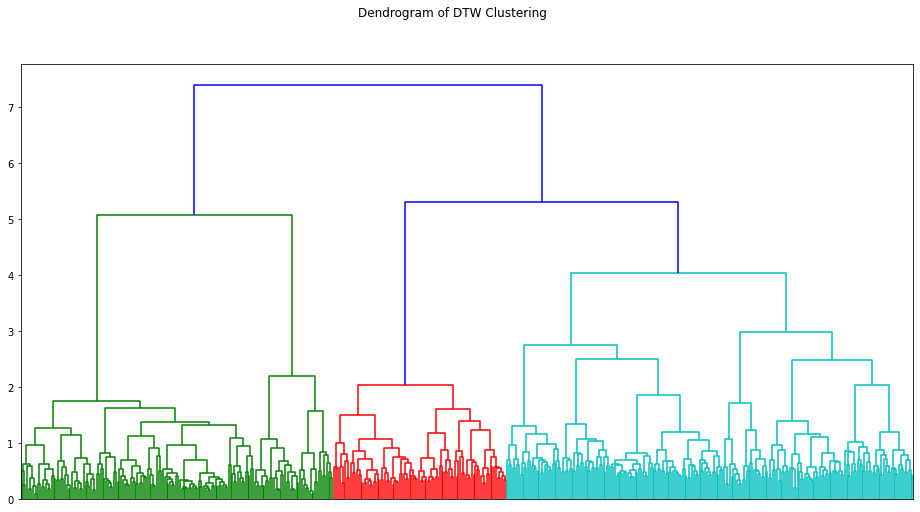

In [ ]:
linkage_matrix = ward(distance_matrix)
fig = plt.figure(figsize=(16, 8))
dn = dendrogram(linkage_matrix, no_labels=True)
fig.suptitle('Dendrogram of DTW Clustering')
plt.show()

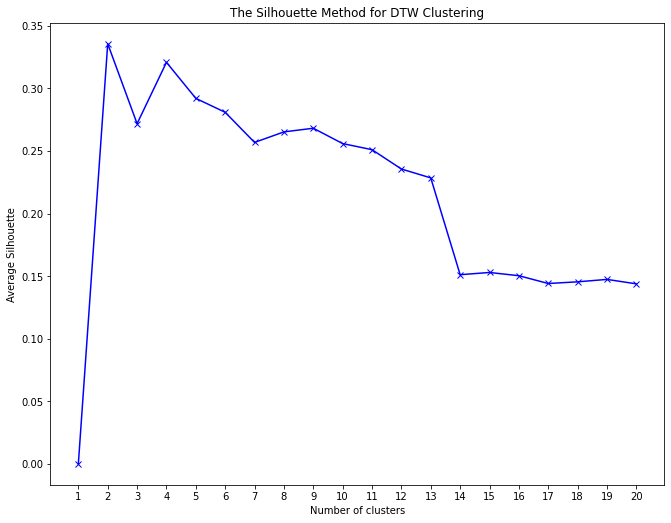

In [ ]:
square_linkage_matrix = squareform(distance_matrix + distance_matrix.T)
linkage_matrix = linkage(distance_matrix, method="ward")

scores = [0]
max_clust = 20
for n_clust in range(2,max_clust+1):
    assignments = fcluster(linkage_matrix, n_clust, criterion='maxclust')
    
    score = silhouette_score(square_linkage_matrix, assignments)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,max_clust+1), np.array(scores), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette')
plt.title('The Silhouette Method for DTW Clustering')
plt.xticks(list(range(1,max_clust+1)))
plt.show()

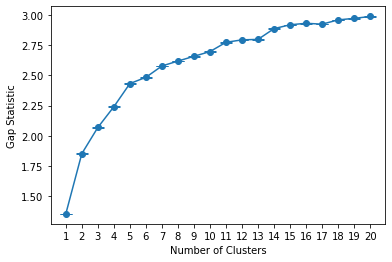

In [ ]:
gs_obj = OptimalK()
max_clust = 20

_ = gs_obj(square_linkage_matrix, n_refs=500, cluster_array=np.arange(1, max_clust+1))

def plot_gap(gap_mat):
    gaps = gap_mat["gap_value"].values
    diffs = gap_mat["diff"]
    
    err_bars = np.zeros(len(gap_mat))
    err_bars[1:] = diffs[:-1] - gaps[:-1] + gaps[1:]

    plt.scatter(gap_mat["n_clusters"], gap_mat["gap_value"])
    plt.errorbar(gap_mat["n_clusters"], gap_mat["gap_value"], yerr=err_bars, capsize=6)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Gap Statistic")
    plt.xticks(np.arange(1, max_clust+1, step=1))
    plt.show()
    
plot_gap(gs_obj.gap_df)

In [ ]:
four_cluster_labels = fcluster(linkage_matrix, 4, criterion='maxclust')
five_cluster_labels = fcluster(linkage_matrix, 5, criterion='maxclust')
cluster_labels_df = pd.DataFrame({'ASV': list(asv_abundance_filtered.iloc[:,:-5].columns), 'four_cluster_labels': four_cluster_labels, 'five_cluster_labels': five_cluster_labels})
print('Number of ASVs in each cluster:')
cluster_labels_df.four_cluster_labels.value_counts()

Number of ASVs in each cluster:


4    216
1    124
3     92
2     42
Name: four_cluster_labels, dtype: int64

In [ ]:
only_asv_abundance_filtered = asv_abundance_filtered.iloc[:,:-5]
only_asv_abundance_filtered_trans = only_asv_abundance_filtered.transpose(copy=True)
only_asv_abundance_filtered_trans.set_index(cluster_labels_df.four_cluster_labels, append=True, inplace=True)
only_asv_abundance_filtered = only_asv_abundance_filtered_trans.transpose(copy=True)
cluster_df = only_asv_abundance_filtered.groupby(level=1,axis=1).sum() #.merge(metadata, left_index=True, right_on='sampleID')
cluster_df.rename(columns={1:'cluster_1',2:'cluster_2',3:'cluster_3',4:'cluster_4'},inplace=True)
cluster_df = cluster_df.merge(asv_abundance_filtered.iloc[:,-5:], left_index=True, right_index=True)
cluster_df.describe()

cluster_1    cluster_2  ...     subject        time
count   686.000000   686.000000  ...  686.000000  686.000000
mean    173.884744    41.869626  ...    5.992711   33.130466
std     369.274591   274.537220  ...    2.576979   19.707888
min       0.000000     0.000000  ...    2.000000    0.000000
25%       0.000000     0.000000  ...    4.000000   18.000000
50%       2.856972     0.000000  ...    6.000000   35.000000
75%     235.734327     0.000000  ...    8.000000   50.500000
max    5898.761385  6079.644730  ...   10.000000   64.500000

[8 rows x 6 columns]

## Cluster Using Hamming Distance

The hamming distance measures the number of positions where the corresponding gene sequence is different between two ASVs. With this clustering technique, we matched ASVs into three groups based on the hierarchical clustering dendrogram. This method allows us to observe the relative abundance of clusters of ASVs that are genetically similar to each other for three clusters. 


In [ ]:
#Hamming Distance Clusters
ham_asvs = asv_abundance_filtered.iloc[:,0:474].columns
emil_asv = asv_and_taxonomy[asv_and_taxonomy.name.isin(ham_asvs)]
emil_asv = emil_asv.reset_index(drop=True)

#Get the gene sequences
seq = emil_asv.sequence

#Get the lengths
len_seq = seq.apply(lambda x: len(x))
len_seq.value_counts()

#Function for pair-wise hamming distance
def hamming_distance(chain1, chain2):
    return sum(c1 != c2 for c1, c2 in zip(chain1, chain2))

#List to store hamming distance
ham_dis = []

#For each pair, run the hamming distance function
for i in seq:
  ham_dis_line = []
  for j in seq:
    ham_dis_line.append(hamming_distance(i,j))
  ham_dis.append(ham_dis_line)

#Got the "closest ASV by hamming distance"
ham_arg = np.argsort(ham_dis)

#Prepare a matrix of the hamming distances
ham_mat = np.matrix(ham_dis)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


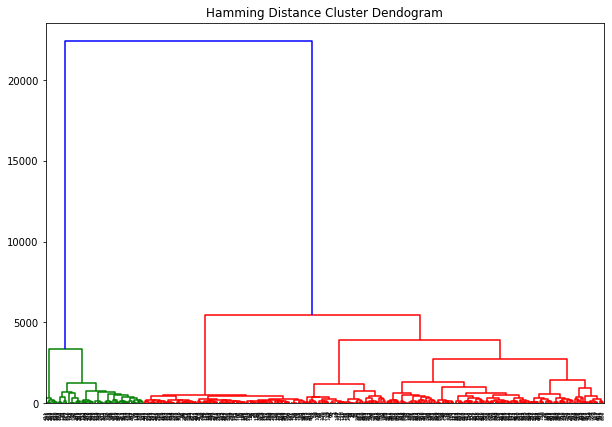

In [ ]:
#Hierarchical clustering dendogram using the hamming distance

plt.figure(figsize=(10, 7))
plt.title("Hamming Distance Cluster Dendogram")
dend = shc.dendrogram(shc.linkage(ham_mat, method='ward'))

In [ ]:
#From Dendogram, 3 clusters seem reasonable
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clus_assign = cluster.fit_predict(ham_mat)

#Naming convention is kept from previous 4-cluster to ensure subsequent code runs
emil_asv['cluster_4'] = clus_assign
emil_asv.groupby("cluster_4").count()

#Save csv file
asv_474_hamdis_cluster3 = emil_asv[['name','cluster_4']]
asv_474_hamdis_cluster3.to_csv('hamdis_474_asv_cluster3.csv')

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [ ]:
ham_clusters = asv_474_hamdis_cluster3.copy()

# Forecasting Models

## Info on models

We considered and tested three models of varying complexity to forecast the abundance of different taxa or clusters of taxa. These include an autoregression model, a generalized Lotka-Volterra (gLV) estimated with constrained linear regression, and a gLV model estimated using ridge regression. We discussed the autoregression previously, and decided it did not capture the rich set of features needed to predict trajectories. Ultimately, we proceeded with the gLV model estimated with constrained linear regression as the ridge regression did not add much value and required too many decisions that were difficult to justify theoretically. 

We discuss the specific implementation of our gLV method, our rationale of the decisions we had to make, and the results and limitations below.


## Lotka-Volterra Model

***Implementation*** 

For the Generalized Lotka-Volterra (gLV) model, we use the implementation described in Travis’ lecture and combine it with guidance from this paper describing a “Web-gLV” application. This model estimates the change in the log abundance of a particular taxa or a cluster of taxa using a linear OLS regression. This is detailed in the equation below:


$\frac{ln(x_{i,k}(t+1)) - ln(x_{i,k}(t))}{\Delta t} = r_i + \sum_{l=1}^7 \gamma_{i,k,l}*h_{i,k,l}(t) + \sum_{j=1}^4 \alpha_{i,j,k}*x_{j,k}(t)$



More specifically, this equation predicts the change in log relative abundance between successive time periods for a cluster of taxa as a function of its intrinsic growth rate, perturbations to the environment, and the abundance of other clusters. We have assumed linear separability of these perturbation terms, as noted by Travis in lecture. While this is easier to model, it is conceptually different than a multiplicative perturbation term with the growth rate in that it assumes perturbation growth is independent of intrinsic growth.

To estimate these parameters, we modeled the gLV equation using a combination of OLS and optimization methods in the Scipy ‘Optimize’ package. Optimization was necessary as we applied constraints to some of our coefficients. We constrain the values of the intrinsic growth constant to be positive and the self-interaction term to be negative. This is in line with recommendations from the literature and lectures about what is biologically realistic.

***Training***

To train the gLV model, we set aside one subject within each cohort (sick vs ulcerative colitis) to test our data. We then train one gLV model for each cohort by averaging the abundances of the training mice within each cohort and fitting our constrained regression model on those average abundances. The parameters tell us how much we can expect the log abundance of a cluster of taxa to change between two time periods, which we can use to predict how much the same clusters should change in our test mice.

This setup corresponds to a situation where one is predicting the outcomes on a subject given information about an intervention on other subjects. We chose this approach, rather than leaving out a set of time periods, because this seemed more plausible as a scenario we might encounter (we also consulted Travis and he approved). Doctors will likely have to predict how a series of interventions will affect a patient having seen other patients, which our setup corresponds to well. The downside is that we have very few samples, leading to very noisy predictions. For conceptual clarity, however, we believe this is the appropriate tradeoff given the limited data available.

Once we estimate the changes in the log abundances for a taxa cluster at each time period, we assume that we can observe the first true abundance in the test data. Since the estimate is of the change in log abundance, we obtain the ratio change of true abundance when we exponentiate our prediction. We then apply these ratio changes to the test data row-by-row, first multiplying this obtained ratio by the true abundance in the first time period, then applying successive ratios by their newly predicted abundances.

**Evaluation**

Finally, we evaluated the success of our models using both traditional measures of goodness-of-fit such as mean-squared-error and R-squared as well as measures we felt were more appropriate, including mean absolute deviation and Dynamic Time Warp. Dynamic Time Warp calculates the similarity of trajectories as a number between 0 and 1, where 1 is a mirror image of similarity and 0 is exact similarity, so numbers closer to 0 are preferred.

Ultimately, we relied on the Dynamic Time Warp because of the non-linearity of our model and the presence of significant outliers. We felt that even if our R^2 was high or very low, it was more instructive to characterize and compare the entire trajectory of our predicted and training models to make sure we captured “hills and valleys,” as that indicates a better representation of the underlying dynamics.


In [ ]:
def prep_df_for_glv(df, test_subject, healthy_cohort: bool):
    '''
    INPUT ASV DATA, TEST SUBJECT NUMBER, AND WHETHER YOU WANT HEALTHY OR UC COHORT (TRUE/FALSE)
    OUTPUTS TEST SUBJECT DF, TRAINING DF, ASV COLUMNS, AND PERTURBATION COLUMNS

    Assumes following input data structure:
      - First n cols are taxa
      - Last 5 columns are basic metadata
    '''
    # sort data by time
    df = df.sort_values('time').reset_index(drop=True)
    if healthy_cohort is True:
        df = df[df.cohort=='healthy']
    else:
        df = df[df.cohort!='healthy']

    # drop samples that aren't present across all mice
    missing_samps = []
    for i in df.subject.unique():
        for j in df.subject.unique():
            if i !=j:
                if len(df.loc[df.subject==i].loc[df.loc[df.subject==i,'time'].isin(df.loc[df.subject==j,'time'])==False])>0:
                    for t in df.loc[df.subject==i].loc[df.loc[df.subject==i,'time'].isin(df.loc[df.subject==j,'time'])==False].time:
                        missing_samps.append(t)
    samps_to_drop = set(missing_samps)
    df_dropped_samps = df[(df.time.isin(samps_to_drop)==False)]

    # create dummy vars for perturbations
    glv_df = pd.concat([df_dropped_samps, pd.get_dummies(df_dropped_samps.treatment_state)], axis=1)

    # filter out test subject data and create a new df containing test data
    test_subject_df = glv_df[glv_df.subject==test_subject]
    glv_df = glv_df[glv_df.subject!=test_subject]

    # identify taxa columns and perturbation columns
    taxa_cols = list(glv_df.columns)[0:-12]
    pert_cols = list(glv_df.columns)[-7:]

    # aggregate the data by taking the mean abundance across mice for each taxa
    glv_df_agg = glv_df[taxa_cols+['time']].groupby('time').mean()
    glv_df_agg = glv_df_agg.merge(glv_df[pert_cols+['time']].drop_duplicates(subset='time'), left_index=True, right_on='time')

    # add a small constant (1/read depth) to all abundances in order to get rid of 0s
    #glv_df_agg[taxa_cols] = glv_df_agg[taxa_cols]+(1/glv_df_agg[taxa_cols].sum().sum())
    glv_df_agg.loc[:,taxa_cols] = glv_df_agg.loc[:,taxa_cols]+1
    glv_df_agg.loc[:,taxa_cols] = glv_df_agg.loc[:,taxa_cols]+(1/glv_df_agg[taxa_cols].sum().sum())
    glv_df_agg.drop('time',axis=1,inplace=True)

    return test_subject_df, glv_df_agg, taxa_cols, pert_cols



def glv(prepped_df, taxa_cols, pert_cols):
    '''
    Input: prepped dataframe, list of taxa columns, list of perturbation cols
    Output: tuple with dataframe of coefficients from model and metrics, dataframe with predictions and original values
    '''
    all_model_info = np.zeros(shape=len(prepped_df.columns)+3)
    
    # get list of covariates
    covars = taxa_cols + pert_cols
    
    glv_df_taxa_preds = prepped_df.copy().reset_index(drop=True)
    for taxa in taxa_cols:
        
        # Create copy of glv_df for this run of model
        glv_df_taxa = prepped_df.copy().reset_index(drop=True)
        
        # Take logs of just the y values! Then compute change
        glv_df_taxa[taxa+'_log'] = np.log(glv_df_taxa[taxa])
        
        # Add difference column (keep log or not log depending on which makes sense)
        glv_df_taxa[taxa+'_log_change'] = -glv_df_taxa[taxa+'_log'].diff(-1)
        
        # Drop last row (no data on change for last sample)
        glv_df_taxa = glv_df_taxa.drop(glv_df_taxa.index[-1])
        
        
        ### Run regression to estimate glv parameters for ASV 10
        # Define X and y vars
        A = glv_df_taxa.loc[:,covars].copy()
        A.insert(0, 'constant', np.ones(len(A)))
        b = glv_df_taxa[taxa+'_log_change']
        
        ## Define bounds as vectors

        # lower bound
        lb = np.full((len(covars),),-np.inf)
        lb = np.insert(lb, 0, 0)
        
        # upper bound
        ub = np.full(((len(covars)-1),),np.inf)
        ub = np.insert(ub, covars.index(taxa), 0)
        ub = np.insert(ub, 0, np.inf)
        
        # Run model
        res = lsq_linear(A, b, bounds=(lb, ub), lsmr_tol='auto', verbose=1)

        # Exponentiate changes in log to get actual change ratio
        glv_df_taxa[taxa+'_pred_change'] = np.exp(np.dot(A, res.x))

        ## Apply actual change to each time period to get predicted abundances

        # Create column that is predicted quantities at each time based on predicted changes
        # First row should be original value
        glv_df_taxa[taxa+'_pred'] = glv_df_taxa[taxa]
        glv_df_taxa_preds[taxa+'_pred'] = glv_df_taxa[taxa+'_pred']
        
        # All others are pred change times prior row value (because of logs), taking initial measurement as given
        for row in range(1, len(glv_df_taxa)):
            glv_df_taxa.loc[row, taxa+'_pred'] = glv_df_taxa.loc[row-1, taxa+'_pred_change']*glv_df_taxa.loc[row-1, taxa+'_pred'] 
        
        # calculate metrics on training data
        r2 = metrics.r2_score(y_true=glv_df_taxa[taxa], y_pred=glv_df_taxa[taxa+'_pred'])
        mse = metrics.mean_squared_error(y_true=glv_df_taxa[taxa], y_pred=glv_df_taxa[taxa+'_pred'])
        model_metrics = np.array([r2,mse])

        model_info = np.append(res.x, model_metrics)
        all_model_info = np.vstack((all_model_info,model_info))
    
    # Create results dataframe that stores model coefficients and fit metrics
    results_df_columns = ['growth_rate']+covars+['r2','mse']
    glv_model_data = pd.DataFrame(data=all_model_info, columns=results_df_columns)

    # Add column for taxa being predicted and delete first row of df
    glv_model_data = glv_model_data.drop(glv_model_data.index[0])
    glv_model_data['pred_taxa'] = taxa_cols

    return glv_model_data, glv_df_taxa_preds



def predict_gLV(model_coefs, test_data, taxa_cols):
    
    test_data = test_data.copy().drop(['sampleID','subject',	'time','cohort', 'treatment_state'], axis=1)
    model_coefs = model_coefs.drop(['r2','mse'],axis=1)
    
    # get list of covariates
    covars = list(test_data.columns)
    
    glv_df_taxa_preds = test_data.copy().reset_index(drop=True)
    for taxa in taxa_cols:
        
        # Create copy of glv_df for this run of model
        glv_df_taxa = test_data.copy().reset_index(drop=True)
        glv_df_taxa.insert(0, 'constant', np.ones(len(glv_df_taxa)))
        
        taxa_coefs = model_coefs[model_coefs.pred_taxa==taxa].iloc[:,:-1]
        
        # Exponentiate changes in log to get actual change ratio
        glv_df_taxa[taxa+'_pred_change'] = np.exp(np.dot(glv_df_taxa, taxa_coefs.values[0]))

        ## Apply actual change to each time period to get predicted abundances

        # Create column that is predicted quantities at each time based on predicted changes
        # First row should be original value
        glv_df_taxa[taxa+'_pred'] = glv_df_taxa[taxa]
        
        # All others are pred change times prior row value (because of logs), taking initial measurement as given
        for row in range(1, len(glv_df_taxa)):
            glv_df_taxa.loc[row, taxa+'_pred'] = glv_df_taxa.loc[row-1, taxa+'_pred_change']*glv_df_taxa.loc[row-1, taxa+'_pred'] 
        
        glv_df_taxa_preds[taxa+'_pred'] = glv_df_taxa[taxa+'_pred']

    return glv_df_taxa_preds

gLV Predictions on test subject for healthy cohort

In [ ]:
test_subject_df, glv_df_agg, taxa_cols, pert_cols = prep_df_for_glv(cluster_df,2,healthy_cohort=True)
glv_results_filtered_asv_df, glv_df_taxa = glv(glv_df_agg, taxa_cols, pert_cols)
glv_model_preds = predict_gLV(glv_results_filtered_asv_df, test_subject_df, taxa_cols)
glv_model_preds

The unconstrained solution is optimal.
Final cost 8.4006e+00, first-order optimality 2.58e-08
The relative change of the cost function is less than `tol`.
Number of iterations 17, initial cost 3.2136e+04, final cost 8.9489e+00, first-order optimality 1.35e-09.
The unconstrained solution is optimal.
Final cost 5.8217e+00, first-order optimality 5.27e-08
The unconstrained solution is optimal.
Final cost 1.7543e+00, first-order optimality 3.49e-08


cluster_1    cluster_2  ...  cluster_3_pred  cluster_4_pred
0    15.309235   323.490782  ...    1.996857e+00      946.842876
1   283.065875   294.579073  ...    1.145871e+01     2638.819249
2   229.392184  1614.434386  ...    4.564304e+01     7114.470661
3    12.497718   265.860548  ...    4.250060e+01     3446.005057
4   122.461770   164.616366  ...    1.900864e+02     5871.261365
..         ...          ...  ...             ...             ...
70  456.690878     0.000000  ...    6.524998e+09    11737.426129
71  467.131982     0.000000  ...    6.043896e+09    13227.526202
72  181.644704     0.000000  ...    4.205400e+09     9279.622724
73  336.637750     0.000000  ...    7.794672e+09    19251.217026
74  417.022034     0.000000  ...    8.008730e+09    19897.879275

[75 rows x 15 columns]

In [ ]:
scaler = StandardScaler()
model_results_scaled = scaler.fit_transform(glv_model_preds[['cluster_1','cluster_1_pred','cluster_2','cluster_2_pred','cluster_3','cluster_3_pred','cluster_4','cluster_4_pred']])
model_results_scaled = pd.DataFrame(data=model_results_scaled, columns = ['cluster_1','cluster_1_pred','cluster_2','cluster_2_pred','cluster_3','cluster_3_pred','cluster_4','cluster_4_pred'])

In [ ]:
distances = []
for cluster in ['cluster_1','cluster_2','cluster_3','cluster_4']:
    maxSAD_true = np.sum(np.abs(model_results_scaled[cluster].values*2))
    maxSAD_pred = np.sum(np.abs(model_results_scaled[cluster+'_pred'].values*2))
    avg_maxSAD = np.mean([maxSAD_true, maxSAD_pred])
    alignment = dtw(model_results_scaled[cluster+'_pred'].values, model_results_scaled[cluster].values)
    time_dtw = alignment.distance/avg_maxSAD
    distances.append(time_dtw)

model_pred_dtw_distances = dict(zip(['cluster_1','cluster_2','cluster_3','cluster_4'], distances))
print('The TIME-nomalized DTW distances between the true and predicted cluster trajectories:')
model_pred_dtw_distances

The TIME-nomalized DTW distances between the true and predicted cluster trajectories:


{'cluster_1': 0.46999833352783615,
 'cluster_2': 0.33214690059986735,
 'cluster_3': 0.4512562555708429,
 'cluster_4': 0.33881791086258434}

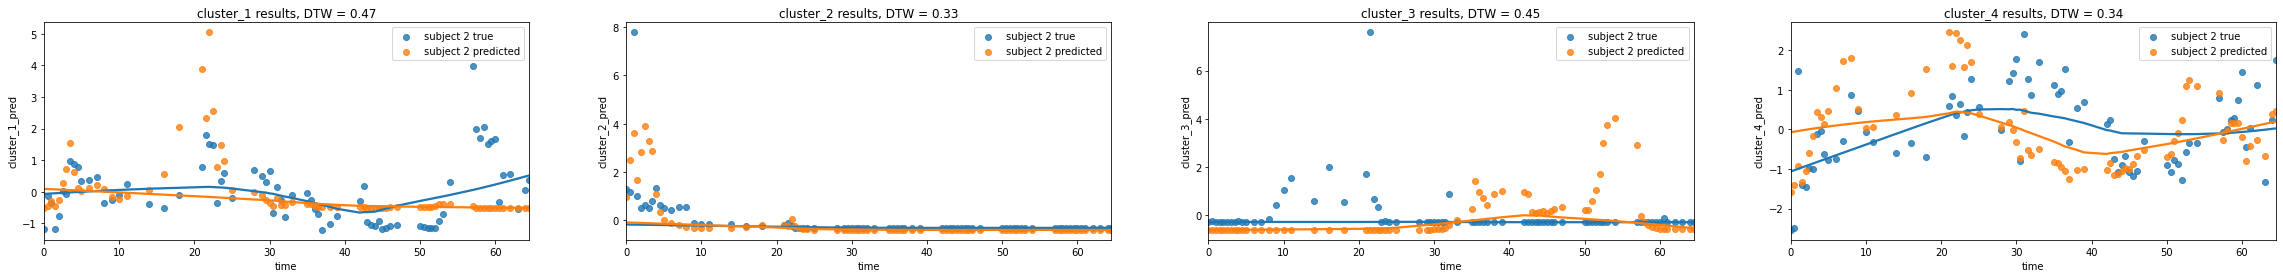

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(40,4))
for i, cluster in enumerate(['cluster_1','cluster_2','cluster_3','cluster_4']):
    plot = sns.regplot(x=test_subject_df.time, y=model_results_scaled[cluster], scatter=True, label="subject 2 true", lowess=True, ax=axs[i])
    plot = sns.regplot(x=test_subject_df.time, y=model_results_scaled[cluster+'_pred'], scatter=True, label="subject 2 predicted", lowess=True, ax=axs[i])
    plot.legend()
    plot.set_title(f'{cluster} results, DTW = {np.round(model_pred_dtw_distances[cluster],2)}')
plt.show()

gLV Predictions on test subject for cohort with Ulcerative Colitis

In [ ]:
test_subject_df, glv_df_agg, taxa_cols, pert_cols = prep_df_for_glv(cluster_df,9,healthy_cohort=False)
glv_results_filtered_asv_df, glv_df_taxa = glv(glv_df_agg, taxa_cols, pert_cols)
glv_model_preds = predict_gLV(glv_results_filtered_asv_df, test_subject_df, taxa_cols)
#glv_model_preds

The unconstrained solution is optimal.
Final cost 2.4509e+01, first-order optimality 1.85e-06
The unconstrained solution is optimal.
Final cost 2.0934e+00, first-order optimality 2.57e-07
The unconstrained solution is optimal.
Final cost 6.3035e+00, first-order optimality 7.16e-08
The unconstrained solution is optimal.
Final cost 1.0794e+00, first-order optimality 2.27e-07


In [ ]:
scaler = StandardScaler()
model_results_scaled = scaler.fit_transform(glv_model_preds[['cluster_1','cluster_1_pred','cluster_2','cluster_2_pred','cluster_3','cluster_3_pred','cluster_4','cluster_4_pred']])
model_results_scaled = pd.DataFrame(data=model_results_scaled, columns = ['cluster_1','cluster_1_pred','cluster_2','cluster_2_pred','cluster_3','cluster_3_pred','cluster_4','cluster_4_pred'])

In [ ]:
distances = []
for cluster in ['cluster_1','cluster_2','cluster_3','cluster_4']:
    maxSAD_true = np.sum(np.abs(model_results_scaled[cluster].values*2))
    maxSAD_pred = np.sum(np.abs(model_results_scaled[cluster+'_pred'].values*2))
    avg_maxSAD = np.mean([maxSAD_true, maxSAD_pred])
    alignment = dtw(model_results_scaled[cluster+'_pred'].values, model_results_scaled[cluster].values)
    time_dtw = alignment.distance/avg_maxSAD
    distances.append(time_dtw)

model_pred_dtw_distances = dict(zip(['cluster_1','cluster_2','cluster_3','cluster_4'], distances))
print('The TIME-nomalized DTW distances between the true and predicted cluster trajectories:')
model_pred_dtw_distances

The TIME-nomalized DTW distances between the true and predicted cluster trajectories:


{'cluster_1': 0.840239185330578,
 'cluster_2': 0.09486574492691315,
 'cluster_3': 0.4540649448051167,
 'cluster_4': 0.38816187968462795}

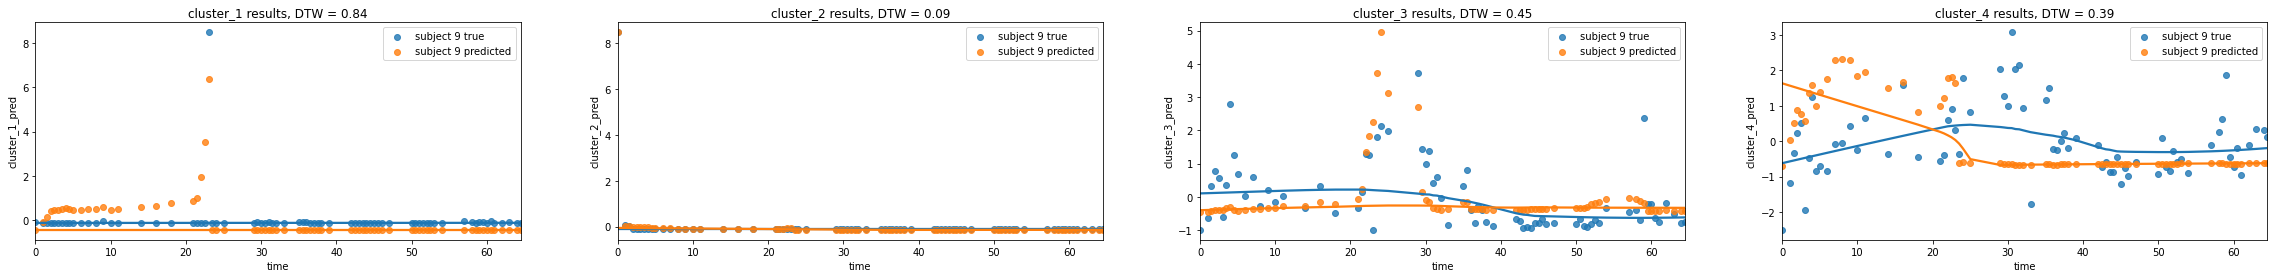

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(40,4))
for i, cluster in enumerate(['cluster_1','cluster_2','cluster_3','cluster_4']):
    plot = sns.regplot(x=test_subject_df.time, y=model_results_scaled[cluster], scatter=True, label="subject 9 true", lowess=True, ax=axs[i])
    plot = sns.regplot(x=test_subject_df.time, y=model_results_scaled[cluster+'_pred'], scatter=True, label="subject 9 predicted", lowess=True, ax=axs[i])
    plot.legend()
    plot.set_title(f'{cluster} results, DTW = {np.round(model_pred_dtw_distances[cluster],2)}')
plt.show()

## Results

The general features of the test trajectories were captured by our model, though the model did a much better job on the healthy cohort than the UC cohort and on clusters 2 and 4 rather than cluster 3. The results also indicate some level of overfitting, which we partially attribute this to the limited number of samples used to train. 

Interestingly, some of the estimates are not wrong in magnitude, but they spike at unexpected intervals, perhaps showing that heterogeneity of mice within cohorts may be an important factor for further analysis.

The noise, as noted earlier, is significant, likely due to the limited number of samples in the training data. Furthermore, in both the healthy and UC mice, we see that in cluster 4, the spike in abundance is predicted earlier than actually occurs, indicating that perhaps our model "jumps the gun" with the perturbations. Overall however, the models do capture the hills and valleys of abundance change to some degree.


## Discussion and Thoughts for Future Research
Overall, we have three key observations about our model when performed on our preferred clusters:

*   Abundant clusters had more discernible dynamics
*   Healthy mice had more changes across clusters
*   Perturbations matter, but not always in the same ways


This model was our preferred model as it was conceptually the most sophisticated and also used all of the input data in its predictions. 

The gLV with perturbations worked particularly well for certain clusters, but it was quite inaccurate for others. While the hills and valleys are clearly visible in its predictions, there are some estimates that are far above of magnitude out of what we should see or that rise and fall earlier than actually occurs.

We tried to optimize this model by tuning some of the hyperparameters. For instance, we added tighter constraints on the perturbation terms and removed some of them. We also tried unconstrained ridge regression with varying levels of alpha to see if that would dampen the most extreme predictions. Ultimately however, many of these adjustments did not add much predictive value, and more importantly, we could not justify some of these adjustments theoretically. Therefore, we decided to stick with the original gLV implementation as our final model.

For future research however, tweaking the constraints applied the coefficients and reducing the number of covariates may help increase the accuracy gLV.  Combined with more data samples, further work that incorporates regularization with a theoretically justifiable rationale could help achieve a better result.
